## Import dependencies

In [1]:
## Get dependencies ##

import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
sys.path.append('..')
from GIR import *
import scipy as sp
import pickle
import time
import scipy as sp
from scipy import signal
from scipy.io.idl import readsav
import os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob
import requests
import ftplib
import io
import cmocean
from bs4 import BeautifulSoup
import urllib.request
from io import StringIO, BytesIO
from zipfile import ZipFile
import tqdm
import seaborn as sn
import re

## get SSP emissions
from tools.RCMIP import *

GCP_historical_emissions=pd.read_csv('https://raw.githubusercontent.com/openclimatedata/global-carbon-budget/master/data/historical-budget.csv',index_col=0,usecols=[0,1,2])
# set 1750 value to 0
GCP_historical_emissions.loc[1750,'Fossil-Fuel-Industry'] = 0
# linearly interpolate between 0 and first land-use-change datapoint
GCP_historical_emissions.loc[1750:1849,'Land-Use-Change'] = np.linspace(0,0.99,100) * GCP_historical_emissions.loc[1850,'Land-Use-Change']

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}
    
## Pandas options setup

pd.set_option('display.max_columns', 100)
    
## Matplotlib rcparams setup:

matplotlib.rcParams['font.family']='Helvetica'
matplotlib.rcParams['font.size']=11
# matplotlib.rcParams['font.weight']=400

matplotlib.rcParams['image.cmap']='cmo.ice'

matplotlib.rcParams['axes.prop_cycle']=matplotlib.cycler('color',['011936','FF7D00','225560','BFACAA','D72638','788C9B','A33F00','7CAAB0','685655','EB767C'])
matplotlib.rcParams['axes.formatter.limits']=-3,3
# matplotlib.rcParams['axes.labelweight']=300

matplotlib.rcParams['legend.frameon']=False

matplotlib.rcParams['boxplot.whiskers']=(5,95)
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.medianprops.color']='black'

matplotlib.rcParams['errorbar.capsize']=5

matplotlib.rcParams['hist.bins']='auto'

plt.rcParams['pdf.fonttype'] = 42

%matplotlib inline

%load_ext line_profiler
%load_ext memory_profiler

/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
../tools/RCMIP.py:61: PerformanceWarning: indexing past lexsort depth may impact performance.
  GIR_to_RCMIP_map.loc[RCMIP_to_GIR_map_concs.values(),'RCMIP_concs_unit'] = RCMIP_concs.loc[('World','ssp245')].reindex(RCMIP_to_GIR_map_concs.keys()).loc[:,'Unit'].values#.loc[('World','ssp245',RCMIP_to_GIR_map_concs.keys()),'Unit'].values


## Contents:
- SSP inverse emissions (CO2 CH4 N2O)
- SSP concentrations (CO2 CH4 N2O)
- SSP forcings
- SSP temperature plumes
- Comparison of C4MIP / FaIR carbon cycle feedback parameters?

### Supplementary figures
- comparison of the FaIR and GIR carbon cycle
- Etminan comparison (OLBL vs Etminan formulae)
- comparing the CH4 lifetime computation with Holmes
- 1pctCO2 / abrupt4xCO2, compare to CMIP6
- compare SSPs to CMIP6?

# NROY Ensemble Generation

## Part I: the Global Warming Index

In [2]:
## Import data
baseline = ['1861','1880']

url = "https://www.metoffice.gov.uk/hadobs/hadcrut4/data/current/time_series/HadCRUT.4.6.0.0.monthly_ns_avg.txt"
req = requests.get(url, headers=header)
data = StringIO(req.text)
HadCRUT4 = pd.read_csv(data,delim_whitespace=True,index_col=0,names=['date','anom','lower_bias','upper_bias','lower_measure','upper_measure','lower_cover','upper_cover','lower_bias_measure','upper_bias_measure','lower_full','upper_full']).apply(pd.to_numeric)
HadCRUT4.index = pd.to_datetime(['-'.join(x.split('/'))+'-01' for x in HadCRUT4.index])
HadCRUT4 = HadCRUT4['anom'].rename('HadCRUT4')

GISS = pd.read_csv("https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.txt",skiprows=7,skipfooter=7,delim_whitespace=True,index_col=0).iloc[:,:12]
GISS = GISS.loc[GISS.index!='Year'].replace('****',np.nan).apply(pd.to_numeric)/100
month_map = dict(zip(GISS.columns,["{:02d}".format(x) for x in np.arange(1,13)]))
GISS = pd.DataFrame(GISS.values.flatten(),index = pd.to_datetime([x+'-'+month_map[y]+'-01' for x in GISS.index for y in GISS.columns]),columns=['anom'])
GISS = GISS['anom'].rename('GISTEMP')

CW_Had4_krig = pd.read_csv("https://www-users.york.ac.uk/~kdc3/papers/coverage2013/had4_krig_v2_0_0.txt",delim_whitespace=True,index_col=0,names=['date','anom','unc_full','unc_cover','unc_ens']).apply(pd.to_numeric)
CW_Had4_krig.index = pd.to_datetime([str(int(x//1))+'-'+"{:02d}".format(int((x % 1)*12)+1)+'-01' for x in CW_Had4_krig.index])
CW_Had4_krig = CW_Had4_krig['anom'].rename('CW')

Berkeley = pd.read_csv("http://berkeleyearth.lbl.gov/auto/Global/Land_and_Ocean_complete.txt",skiprows=76,delim_whitespace=True,usecols=[0,1,2,3],names=['date','month','anom','unc_full'])
Berkeley = Berkeley.iloc[:Berkeley.loc[Berkeley.date=='%'].index.min()].apply(pd.to_numeric)
Berkeley.index = pd.to_datetime(Berkeley.date.astype(str) + Berkeley.month.astype(str),format='%Y%m')
Berkeley = Berkeley['anom'].rename('Berkeley')

parser = 'html.parser'  # or 'lxml' (preferred) or 'html5lib', if installed
resp = urllib.request.urlopen("https://www.ncei.noaa.gov/data/noaa-global-surface-temperature/v5/access/timeseries/")
soup = BeautifulSoup(resp, parser, from_encoding=resp.info().get_param('charset'))
NOAA_fname = [x['href'] for x in soup.find_all('a', href=True) if x['href'].split('.')[1:5]==['mon','land_ocean','90S','90N']][0]
NOAA = pd.read_csv("https://www.ncei.noaa.gov/data/noaa-global-surface-temperature/v5/access/timeseries/"+NOAA_fname,delim_whitespace=True,names=['date','month','anom','unc_full'],usecols=[0,1,2,3]).apply(pd.to_numeric)
NOAA.index = pd.to_datetime(NOAA.date.astype(str) + NOAA.month.astype(str),format='%Y%m')
NOAA = NOAA['anom'].rename('NOAA')

## Combine into a single df

GMST_datasets = pd.concat([HadCRUT4,CW_Had4_krig,GISS,NOAA,Berkeley],axis=1)

## Baseline to 1861:1880 OR to HadCRUT4 20C mean if data begins in 1880 (GISTEMP / NOAA)

GMST_datasets.loc[:,['HadCRUT4','CW','Berkeley']] -= GMST_datasets.loc[baseline[0]:baseline[1],['HadCRUT4','CW','Berkeley']].mean()
GMST_datasets.loc[:,['GISTEMP','NOAA']] -= GMST_datasets.loc['1900':'2000',['GISTEMP','NOAA']].mean() -  GMST_datasets.loc['1900':'2000','HadCRUT4'].mean()

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  # This is added back by InteractiveShellApp.init_path()


<AxesSubplot:>

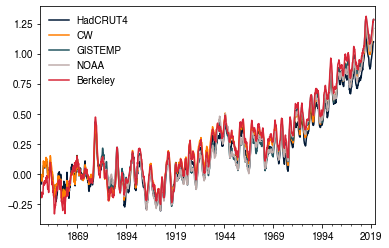

In [3]:
GMST_datasets.rolling(12).mean().plot()

In [4]:
## Import the observational uncertainty from HadCRUT

HadCRUT_ensmem_zip = ZipFile(BytesIO(requests.get('https://www.metoffice.gov.uk/hadobs/hadcrut4/data/current/time_series/HadCRUT.4.6.0.0.annual_ns_avg_realisations.zip').content))
HadCRUT_ensmem_fnames = [x.filename for x in HadCRUT_ensmem_zip.infolist() if x.filename[-4:] == '.txt']
HadCRUT_ensmem_index = pd.read_csv(HadCRUT_ensmem_zip.open(HadCRUT_ensmem_fnames[0]),header=None,delim_whitespace=True,usecols=[0],index_col=0).index
# HadCRUT_ensmem_index = pd.to_datetime(['-'.join(x.split('/'))+'-01' for x in HadCRUT_ensmem_index])
HadCRUT_ensmem = pd.concat([pd.read_csv(HadCRUT_ensmem_zip.open(x),header=None,delim_whitespace=True,usecols=[1]).iloc[:,0].rename(str(i)) for i,x in enumerate(HadCRUT_ensmem_fnames)],axis=1)
HadCRUT_ensmem.index = HadCRUT_ensmem_index

In [5]:
## import forcing ensemble: for now, use the most up-to-date copy I have (.idlsave)

# forcing_dataset = readsav('/home/leachl/Documents/Datasets/RF/1750_Oct2017_forcings.idlsave')
# rf_ant = pd.DataFrame(forcing_dataset['rf_anthro'].byteswap().newbyteorder(),index = pd.to_datetime([str(int(x))+'-01-01' for x in forcing_dataset['year']])).apply(pd.to_numeric)
# rf_nat = pd.DataFrame(forcing_dataset['rf_nat'].byteswap().newbyteorder(),index = pd.to_datetime([str(int(x))+'-01-01' for x in forcing_dataset['year']])).apply(pd.to_numeric)

In [6]:
## creating a forcing response dataset

erf_ar6 = pd.read_csv('https://raw.githubusercontent.com/Priestley-Centre/ssp_erf/master/SSPs/ERF_ssp245_1750-2500.csv',index_col=0,dtype=float)
erf_ar6 -= erf_ar6.loc[1750]

In [7]:
## generating many rf shapes for the GWI

N = 4000

rf_factors = {}

rf_factors['co2'] = sp.stats.norm(1,0.20/1.645).rvs(N)#ppf((erf_ar6.mean()>0).co2*random_percentiles + ~(erf_ar6.mean()>0).co2*(1-random_percentiles))
rf_factors['ch4'] = sp.stats.norm(1,0.28/1.645).rvs(N)#ppf((erf_ar6.mean()>0).ch4*random_percentiles + ~(erf_ar6.mean()>0).ch4*(1-random_percentiles))
rf_factors['n2o'] = sp.stats.norm(1,0.2/1.645).rvs(N)#ppf((erf_ar6.mean()>0).n2o*random_percentiles + ~(erf_ar6.mean()>0).n2o*(1-random_percentiles))
rf_factors['other_wmghg'] = sp.stats.norm(1,0.20/1.645).rvs(N)#ppf((erf_ar6.mean()>0).other_wmghg*random_percentiles + ~(erf_ar6.mean()>0).other_wmghg*(1-random_percentiles))
rf_factors['o3_tropospheric'] = sp.stats.norm(1,0.5/1.645).rvs(N)#ppf((erf_ar6.mean()>0).o3_tropospheric*random_percentiles + ~(erf_ar6.mean()>0).o3_tropospheric*(1-random_percentiles))
rf_factors['o3_stratospheric'] = sp.stats.norm(1,2/1.645).rvs(N)#ppf((erf_ar6.mean()>0).o3_stratospheric*random_percentiles + ~(erf_ar6.mean()>0).o3_stratospheric*(1-random_percentiles))
rf_factors['h2o_stratospheric'] = sp.stats.norm(1,0.72/1.645).rvs(N)#ppf((erf_ar6.mean()>0).h2o_stratospheric*random_percentiles + ~(erf_ar6.mean()>0).h2o_stratospheric*(1-random_percentiles))
rf_factors['contrails'] = sp.stats.norm(1,0.75/1.645).rvs(N)#ppf((erf_ar6.mean()>0).contrails*random_percentiles + ~(erf_ar6.mean()>0).contrails*(1-random_percentiles))
rf_factors['land_use'] = sp.stats.norm(1,0.75/1.645).rvs(N)#ppf((erf_ar6.mean()>0).land_use*random_percentiles + ~(erf_ar6.mean()>0).land_use*(1-random_percentiles))
rf_factors['volcanic'] = sp.stats.norm(1,0.5/1.645).rvs(N)
rf_factors['solar'] = sp.stats.norm(1,1/1.645).rvs(N)

pct_5 = 0.04 / 0.08
pct_95 = 0.18 / 0.08
sigma = (np.log(pct_95) - np.log(pct_5)) / (sp.stats.norm().ppf(0.95)-sp.stats.norm().ppf(0.05))
mu = np.log(pct_5) - sigma * sp.stats.norm().ppf(0.05)
rf_factors['bc_on_snow'] = sp.stats.lognorm(s=sigma,scale=np.exp(mu)).rvs(N)

ant_rf_ensemble = np.zeros((270,N))
nat_rf_ensemble = np.zeros((270,N))

for agent in ['co2','ch4','n2o','other_wmghg','o3_tropospheric','o3_stratospheric','h2o_stratospheric','contrails','land_use','bc_on_snow']:
    ant_rf_ensemble += rf_factors[agent]*erf_ar6.loc[1750:2019,agent].values[:,None]
        
for agent in ['volcanic','solar']:
    nat_rf_ensemble += rf_factors[agent]*erf_ar6.loc[1750:2019,agent].values[:,None]
        
## aerosol distribution 

### generate the mean shape:

RCMIP_so2_emms = RCMIP_emms.loc[('World','ssp245','Emissions|Sulfur')].iloc[4:].apply(pd.to_numeric).interpolate().loc[:'2019'].values[None]
RCMIP_oc_emms = RCMIP_emms.loc[('World','ssp245','Emissions|OC')].iloc[4:].apply(pd.to_numeric).interpolate().loc[:'2019'].values[None]
RCMIP_bc_emms = RCMIP_emms.loc[('World','ssp245','Emissions|BC')].iloc[4:].apply(pd.to_numeric).interpolate().loc[:'2019'].values[None]

RCMIP_so2_emms -= RCMIP_so2_emms[0,0]
RCMIP_oc_emms -= RCMIP_oc_emms[0,0]
RCMIP_bc_emms -= RCMIP_bc_emms[0,0]

ERFari_coefs = pd.read_csv('../Parameter_Sets/CMIP6_ERFari.csv',index_col=0)
ERFaci_coefs = pd.read_csv('../Parameter_Sets/CMIP6_ERFaci.csv',index_col=0)

beta = -1*np.exp(ERFaci_coefs['log_beta'].mean())
s = np.exp(ERFaci_coefs['log_s'].mean())
alpha = ERFaci_coefs['alpha'].mean()

# ERFari_shape = ERFari_coefs.so2.mean() * RCMIP_so2_emms + ERFari_coefs.bc.mean() * RCMIP_bc_emms + ERFari_coefs.oc.mean() * RCMIP_oc_emms
# ERFaci_shape = beta * np.log(1 + RCMIP_so2_emms / s) + alpha * ( RCMIP_oc_emms + RCMIP_bc_emms )

ERFari_shape = erf_ar6.loc[1750:2019,['aerosol-radiation_interactions']].values.T
ERFaci_shape = erf_ar6.loc[1750:2019,['aerosol-cloud_interactions']].values.T

## construct the Smith distributions 
def fit_skewnorm(x,X,percentiles):
    distr = sp.stats.skewnorm(*x)
    return sum(abs(distr.ppf(percentiles) - X))

ERFaci_smith_sknorm_params = sp.optimize.minimize(fit_skewnorm,x0=[1,1,1],args=([0.13,0.59,1.17],[0.05,0.5,0.95]),method='nelder-mead').x
ERFari_smith_sknorm_params = sp.optimize.minimize(fit_skewnorm,x0=[1,1,1],args=([0.07,0.27,0.6],[0.05,0.5,0.95]),method='nelder-mead').x

ERFaci_smith_sknorm_distr = -1*sp.stats.skewnorm(*ERFaci_smith_sknorm_params).rvs(N)[:,None]
ERFari_smith_sknorm_distr = -1*sp.stats.skewnorm(*ERFari_smith_sknorm_params).rvs(N)[:,None]

ERFari_samples = ERFari_smith_sknorm_distr / ERFari_shape[0,-1] * ERFari_shape
ERFaci_samples = ERFaci_smith_sknorm_distr / ERFaci_shape[0,-1] * ERFaci_shape

#### Alternative aerosol generation with varying shapes (work-in-progress):

In [8]:
# ## New aerosol generation methodology, following Smith et al (2020) ; multivariate gaussian distribution, sample parameters, generate shapes from emission data.
# ERFari_params = pd.DataFrame(data=np.array([[ 3.25934432e-02, -3.46653116e-04, -2.48761587e-03],
#        [ 2.48231885e-02, -1.26321908e-02, -9.42090973e-04],
#        [ 2.68560170e-02, -2.08950151e-03, -2.60579679e-03],
#        [ 1.01700746e-01, -3.04192033e-02, -2.63868473e-03],
#        [ 1.46132214e-01, -4.41485999e-02, -6.67827786e-03],
#        [ 1.95732170e-03,  4.15481407e-03, -2.90822562e-03],
#        [-5.61261154e-02,  8.85201623e-03, -7.47602910e-04],
#        [ 3.87211606e-02, -1.42408227e-02, -1.78155606e-03],
#        [ 3.02173214e-03, -3.40228173e-03, -1.25702781e-03],
#        [ 2.54832726e-03,  6.32322444e-05, -2.38863636e-03]]),index=['CanESM5', 'E3SM', 'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G',
#        'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'NorESM2-LM',
#        'UKESM1-0-LL'],columns=['bc', 'oc', 'so2'])

# ERFari_sfs = sp.stats.multivariate_normal(ERFari_params.mean(),ERFari_params.cov()).rvs(N)
# ERFari_samples = (ERFari_sfs[...,None]*RCMIP_emms.loc[('World','ssp245',['Emissions|BC','Emissions|OC','Emissions|Sulfur'])].droplevel((0,1)).iloc[:,4:].apply(pd.to_numeric).interpolate(axis=1).loc[:,:'2019'].values[None,...]).sum(axis=1)

# ### LINEAR ERFaci params
# # ERFaci_params = pd.DataFrame(data=np.array([[-0.23977316,  0.05033984, -0.0026841 ],
# #        [-0.03596736, -0.0061301 , -0.00999338],
# #        [-0.02306089, -0.00397075, -0.00440759],
# #        [-0.04100239, -0.00815999, -0.00296047],
# #        [-0.11952911,  0.01185454, -0.00136009],
# #        [-0.0751146 ,  0.0115965 , -0.00595064],
# #        [-0.00958696,  0.00027465, -0.00252801],
# #        [-0.10616509,  0.01464634, -0.00292868],
# #        [ 0.02490414, -0.02261304, -0.00721553],
# #        [ 0.06822656, -0.01548075, -0.01065098]])
# # ,index=['CanESM5', 'E3SM', 'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G',
# #        'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'NorESM2-LM',
# #        'UKESM1-0-LL'],columns=['bc', 'oc', 'so2'])

# ### LOG so2 ERFaci params
# ERFaci_params = pd.DataFrame(data=np.array([[-8.04936152e-01, -4.33765114e+00, -1.76516101e-02],
#        [ 4.20348167e-01, -4.19165818e+00, -1.57827154e-02],
#        [ 1.67034191e+00, -5.34562320e+00, -8.80674737e-03],
#        [ 2.25088976e+00, -5.57251763e+00, -1.19361347e-02],
#        [-1.80621064e+00, -4.82004944e+00, -1.88411062e-02],
#        [-1.48244252e-01, -4.48450777e+00, -6.70740113e-03],
#        [ 1.03705925e+00, -5.88364385e+00, -1.91422284e-03],
#        [-1.00837014e+00, -4.73118298e+00, -1.30437040e-02],
#        [ 2.07731610e+00, -5.03084334e+00, -1.39245898e-02],
#        [-2.52178641e-01, -3.93423009e+00,  3.35367830e-03]])

# ,index=['CanESM5', 'E3SM', 'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G',
#        'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'NorESM2-LM',
#        'UKESM1-0-LL'],columns=['log_beta', 'log_beta_s', 'alpha'])

# # ERFaci_params.loc[:,'so2_logcoef'] = np.log(-1*ERFaci_params.loc[:,'so2_logcoef'])

# ### LINEAR ERFaci params
# # ERFaci_sfs = sp.stats.multivariate_normal(ERFaci_params.mean(),ERFaci_params.cov()).rvs(N)
# # ERFaci_samples = (ERFaci_sfs[...,None]*RCMIP_emms.loc[('World','ssp245',['Emissions|BC','Emissions|OC','Emissions|Sulfur'])].droplevel((0,1)).iloc[:,4:].apply(pd.to_numeric).interpolate(axis=1).loc[:,:'2019'].values[None,...]).sum(axis=1)

# ### LOG so2 ERFaci params
# beta_samples = -1 * np.exp( sp.stats.norm(ERFaci_params['log_beta'].mean(),ERFaci_params['log_beta'].std()).rvs(N) )[...,None]
# beta_s_samples = np.exp( sp.stats.norm(ERFaci_params['log_beta_s'].mean(),ERFaci_params['log_beta_s'].std()).rvs(N) )[...,None]
# s_samples = -1 * beta_samples / beta_s_samples
# alpha_samples = sp.stats.norm(ERFaci_params['alpha'].mean(),ERFaci_params['alpha'].std()).rvs(N)[...,None]

# RCMIP_so2_emms = RCMIP_emms.loc[('World','ssp245','Emissions|Sulfur')].iloc[4:].apply(pd.to_numeric).interpolate().loc[:'2019'].values[None]
# RCMIP_oc_emms = RCMIP_emms.loc[('World','ssp245','Emissions|OC')].iloc[4:].apply(pd.to_numeric).interpolate().loc[:'2019'].values[None]
# RCMIP_bc_emms = RCMIP_emms.loc[('World','ssp245','Emissions|BC')].iloc[4:].apply(pd.to_numeric).interpolate().loc[:'2019'].values[None]

# ERFaci_samples = beta_samples * np.log(1+RCMIP_so2_emms/s_samples) + alpha_samples * ( RCMIP_oc_emms+RCMIP_bc_emms )

In [9]:
# # we now constrain the ERFari and ERFaci distributions to match the contrained Smith (2020) distributions through a quantile map.

# def fit_skewnorm(x,X,percentiles):
#     distr = sp.stats.skewnorm(*x)
#     return sum(abs(distr.ppf(percentiles) - X))

# ERFaci_smith_sknorm_params = sp.optimize.minimize(fit_skewnorm,x0=[1,1,1],args=([0.13,0.59,1.17],[0.05,0.5,0.95]),method='nelder-mead').x
# ERFari_smith_sknorm_params = sp.optimize.minimize(fit_skewnorm,x0=[1,1,1],args=([0.07,0.27,0.6],[0.05,0.5,0.95]),method='nelder-mead').x

# ERFaci_smith_sknorm_distr = sp.stats.skewnorm(*ERFaci_smith_sknorm_params)
# ERFari_smith_sknorm_distr = sp.stats.skewnorm(*ERFari_smith_sknorm_params)

# def np_quantileatscore(a,score):
    
#     ## assumes both are numpy arrays and returns the quantiles for the score array (ordered)
    
#     return ( (a[:,np.newaxis,...]<score[np.newaxis,...]).sum(axis=0) + (a[:,np.newaxis,...]<=score[np.newaxis,...]).sum(axis=0) ) / (2*a.shape[0])

# ## map ERFaci+ERFari to the Smith distribution:

# aci_percentiles = np_quantileatscore(ERFaci_samples[:,-1],ERFaci_samples[:,-1])
# smith_samples = -1 * ERFaci_smith_sknorm_distr.ppf(1-aci_percentiles)
# ERFaci_samples *= (smith_samples/ERFaci_samples[...,-1])[:,None]

# ari_percentiles = np_quantileatscore(ERFari_samples[:,-1],ERFari_samples[:,-1])
# smith_samples = -1 * ERFari_smith_sknorm_distr.ppf(1-ari_percentiles)
# ERFari_samples *= (smith_samples/ERFari_samples[...,-1])[:,None]

In [10]:
tot_aer = (ERFari_samples+ERFaci_samples).T

ant_rf_ensemble += tot_aer

In [11]:
rf_nat = pd.DataFrame(nat_rf_ensemble,index=np.arange(1750,2020),columns=pd.MultiIndex.from_product([['forcing_'+str(x) for x in np.arange(N)],['forcing']])).loc[:2017]

rf_ant = pd.DataFrame(ant_rf_ensemble,index=np.arange(1750,2020),columns=pd.MultiIndex.from_product([['forcing_'+str(x) for x in np.arange(N)],['forcing']])).loc[:2017]

<AxesSubplot:>

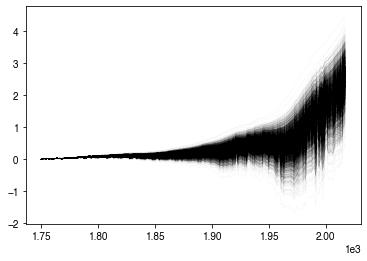

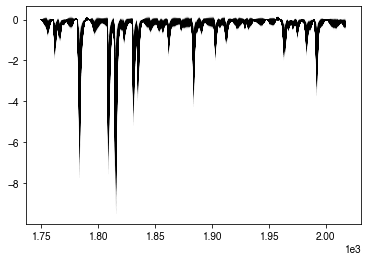

In [12]:
rf_ant.plot(legend=None,lw=0.02,c='k')

rf_nat.plot(legend=None,lw=0.02,c='k')

In [13]:
# # examine the forcing shapes - updated vs old

# forcing_dataset = readsav('/home/leachl/Documents/Datasets/RF/1750_Oct2017_forcings.idlsave')
# rf_ant_old = pd.DataFrame(forcing_dataset['rf_anthro'].byteswap().newbyteorder(),index = forcing_dataset['year']).apply(pd.to_numeric)
# rf_nat_old = pd.DataFrame(forcing_dataset['rf_nat'].byteswap().newbyteorder(),index = forcing_dataset['year']).apply(pd.to_numeric)

In [14]:
# forc_agents = ['CO2', 'Other WMGHG', 'O3 (T)', 'O3(S)','total aerosol ERF','ERF LUC', 'Vapour', 'BC snow', 'contrails']
# AR5_forc = pd.read_csv('/home/leachl/Documents/Datasets/RF/AR5Forcing_ext2015_GHGrevised.txt',skiprows=3,sep='\t',index_col=0)
# assessed_coefs = OLSE_NORM(AR5_forc.iloc[:-3][forc_agents].values,rf_ant_old.values[:-1])['coefs']

In [15]:
# plt.figure(figsize=(10,8))
# plt.hist((AR5_forc['total aerosol ERF'].iloc[:-3].values[:,None]*assessed_coefs[4][None])[-1],density=True,histtype='step',lw=1.5,label='original',cumulative=True)
# plt.hist(tot_aer[-3],density=True,histtype='step',lw=1.5,label='update',cumulative=True)
# plt.legend(loc='upper left')
# plt.title('total aerosol forcing (2017)')

In [16]:
# plt.figure(figsize=(10,8))
# for qtile in [0.05,0.17]:
#     p1 = plt.plot(np.arange(1750,2017),np.quantile(AR5_forc['total aerosol ERF'].iloc[:-3].values[:,None]*assessed_coefs[4][None],qtile,axis=1),c='k',ls='--',lw=0.8)
#     p1 = plt.plot(np.arange(1750,2017),np.quantile(AR5_forc['total aerosol ERF'].iloc[:-3].values[:,None]*assessed_coefs[4][None],1-qtile,axis=1),c='k',ls='--',lw=0.8)
# p1 = plt.plot(np.arange(1750,2017),np.quantile(AR5_forc['total aerosol ERF'].iloc[:-3].values[:,None]*assessed_coefs[4][None],0.5,axis=1),lw=2,color='k',ls='--')

# p1 = plt.fill_between(np.arange(1750,2020),*np.quantile(tot_aer,[0.05,0.95],axis=1),lw=0.1,color='k',alpha=0.3)
# p1 = plt.fill_between(np.arange(1750,2020),*np.quantile(tot_aer,[0.17,0.83],axis=1),lw=0.1,color='k',alpha=0.3)
# p1 = plt.plot(np.arange(1750,2020),np.quantile(tot_aer,0.5,axis=1),lw=2,color='k')
# plt.xlim(1750,2019)
# plt.ylim(-2.5,0.1)

In [17]:
# plt.figure(figsize=(10,8))
# for qtile in [0.05,0.17]:
#     p1 = plt.plot(np.arange(1750,2018),np.quantile(rf_ant_old.values,qtile,axis=1),c='k',ls='--',lw=0.8)
#     p1 = plt.plot(np.arange(1750,2018),np.quantile(rf_ant_old.values,1-qtile,axis=1),c='k',ls='--',lw=0.8)
# p1 = plt.plot(np.arange(1750,2018),np.quantile(rf_ant_old.values,0.5,axis=1),lw=2,color='k',ls='--')

# p1 = plt.fill_between(np.arange(1750,2018),*np.quantile(rf_ant.values,[0.05,0.95],axis=1),lw=0.1,color='k',alpha=0.3)
# p1 = plt.fill_between(np.arange(1750,2018),*np.quantile(rf_ant.values,[0.17,0.83],axis=1),lw=0.1,color='k',alpha=0.3)
# p1 = plt.plot(np.arange(1750,2018),np.quantile(rf_ant.values,0.5,axis=1),lw=2,color='k')
# plt.xlim(1750,2018)
# plt.ylim(-0.5,4)

In [18]:
# rf_ant_old.columns = pd.MultiIndex.from_product([['forcing_'+str(x) for x in np.arange(1000)],['forcing']])
# rf_nat_old.columns = pd.MultiIndex.from_product([['forcing_'+str(x) for x in np.arange(1000)],['forcing']])

In [19]:
## create the response parameter ranges:

### based on inferred ranges from CMIP6
response_names = ['response_'+str(x) for x in np.arange(24)]
response_params = pd.DataFrame(index=['d','q'],columns = pd.MultiIndex.from_product([response_names,[1,2,3]])).apply(pd.to_numeric)
response_params.loc[:] = 0

d1_range = [0.2,0.8,1.4,2]
d2_range = [4,8,12,16]
d3_range = [100,200,400,800]
q1_range = [0.04,0.16,0.28,0.4]

RWF_range = [0.3 , 0.4 , 0.5, 0.6, 0.7, 0.8]
ECS=3

i=0
for d_num in np.arange(4):
    for RWF in RWF_range:
        response_params.loc['d',(response_names[i],1)] = d1_range[d_num]
        response_params.loc['d',(response_names[i],2)] = d2_range[d_num]
        response_params.loc['d',(response_names[i],3)] = d3_range[d_num]
        response_params.loc['q',(response_names[i],1)] = q1_range[d_num]

        q2,q3 = sp.optimize.root(lambda x: q_to_tcr_ecs(response_params.reindex([response_names[i]],axis=1,level=0) + [[0,0],[0,x[0]],[0,x[1]]],F_2x=3.76).values.flatten() - np.array([ECS,ECS*RWF]),x0=np.array([0.32,0.47]),method='lm').x

        response_params.loc['q',(response_names[i],2)] = q2
        response_params.loc['q',(response_names[i],3)] = q3

        i+=1
            
## remove any that are unphysical (negative parameters)

response_params = response_params.reindex([i for i,x in ((response_params<0).sum().unstack().sum(axis=1)==1).iteritems() if not x],axis=1,level=0)

In [20]:
## generate the temperature responses:

### reshape the rf dataframes into model inputs (only for old forcing data):
# rf_ant['YEAR'] = [x.year for x in rf_ant.index]
# rf_ant.set_index('YEAR',inplace=True)
# rf_ant.columns = pd.MultiIndex.from_product([['forcing_'+str(x) for x in rf_ant.columns],['forcing']])
# rf_ant = rf_ant.reindex(rf_ant.index.append(pd.Index([2018,2019])))
# rf_ant.loc[2018] = rf_ant.loc[2017]+(rf_ant.loc[2017] - rf_ant.loc[2012])/5
# rf_ant.loc[2019] = rf_ant.loc[2017]+2*(rf_ant.loc[2017] - rf_ant.loc[2012])/5

# rf_nat['YEAR'] = [x.year for x in rf_nat.index]
# rf_nat.set_index('YEAR',inplace=True)
# rf_nat.columns = pd.MultiIndex.from_product([['forcing_'+str(x) for x in rf_nat.columns],['forcing']])
# rf_nat.loc[2018] = rf_nat.loc[2017]+(rf_nat.loc[2017] - rf_nat.loc[2012])/5
# rf_nat.loc[2019] = rf_nat.loc[2017]+2*(rf_nat.loc[2017] - rf_nat.loc[2012])/5
null_gas_params = pd.read_csv('../Parameter_Sets/Complete_gas_cycle_params.csv',header=[0,1],index_col=0).reindex(['carbon_dioxide'],axis=1,level=1)
##
temp_ant = run_GIR(emissions_in=return_empty_emissions(rf_ant,gases_in=['carbon_dioxide']),gas_parameters=null_gas_params,forcing_in=rf_ant,thermal_parameters=response_params)['T'].droplevel(1,axis=1)
temp_nat = run_GIR(emissions_in=return_empty_emissions(rf_nat,gases_in=['carbon_dioxide']),gas_parameters=null_gas_params,forcing_in=rf_nat,thermal_parameters=response_params)['T'].droplevel(1,axis=1)

# temp_ant_old = run_GIR(emissions_in=return_empty_emissions(rf_ant_old,gases_in=['carbon_dioxide']),gas_parameters=null_gas_params,forcing_in=rf_ant_old,thermal_parameters=response_params)['T'].droplevel(1,axis=1)
# temp_nat_old = run_GIR(emissions_in=return_empty_emissions(rf_nat_old,gases_in=['carbon_dioxide']),gas_parameters=null_gas_params,forcing_in=rf_nat_old,thermal_parameters=response_params)['T'].droplevel(1,axis=1)

Integrating 4000 scenarios, 1 gas cycle parameter sets, 18 thermal response parameter sets, over ['carbon_dioxide'] forcing agents, between 1750 and 2017...


100%|██████████| 267/267 [00:04<00:00, 61.75 timestep/s]


Integrating 4000 scenarios, 1 gas cycle parameter sets, 18 thermal response parameter sets, over ['carbon_dioxide'] forcing agents, between 1750 and 2017...


100%|██████████| 267/267 [00:04<00:00, 56.53 timestep/s]


In [21]:
## generate the temperature dataset:

temp_obs_med = GMST_datasets.mean(axis=1).loc[:str(int(rf_ant.index[-1]))].resample('Y').mean().values

temp_obs_unc = HadCRUT_ensmem.loc[:rf_ant.index[-1]].values - HadCRUT_ensmem.loc[:rf_ant.index[-1]].median(axis=1)[:,np.newaxis]

temp_obs_full = temp_obs_med[:,np.newaxis] + temp_obs_unc

In [22]:
# definition to compute the regressions:
def OLSE_NORM(X,Y,add_intercept=True):
    
    ## computes a multiple OLS regression over a field against several indices. First dimension is time, second is features (X), or targets (Y)
    
    if add_intercept:
    
        X_1 = np.concatenate((np.ones(X.shape[0])[:,np.newaxis],X),axis=1)
        
    else:
        
        X_1 = X.copy()
    
    B = np.dot( np.linalg.inv( np.dot( X_1.T , X_1 ) ) , np.dot( X_1.T , Y ) )
    
    e = Y - np.dot(X_1,B)
    
    SSE = np.sum(e**2,axis=0)

    SST = np.sum((Y - np.mean(Y,axis=0))**2,axis=0)

    R2 = 1 - SSE / SST

#     MSE_var = SSE / (X_1.shape[0] - X_1.shape[-1])

#     SE_B = np.sqrt( np.diag( np.linalg.inv( np.dot( X_1.T , X_1 ) ) )[:,np.newaxis] * MSE_var[np.newaxis,:] )
    return {'coefs':B[1:],'intercept':B[0],'R2':R2}
#     return {'coefs':B[1:],'coef_err':SE_B[1:],'res':e,'intercept':B[0],'intercept_err':SE_B[0]}

In [23]:
ant_coefs = np.zeros((100,temp_ant.shape[1]))
nat_coefs = np.zeros((100,temp_nat.shape[1]))
R2_vals = np.zeros(1000)

# ant_coefs_old = np.zeros((100,temp_ant.shape[1]))
# nat_coefs_old = np.zeros((100,temp_nat.shape[1]))
# R2_vals_old = np.zeros(1000)

for i in tqdm.tqdm(np.arange(ant_coefs.shape[1])):
    _lreg_coefs = OLSE_NORM(np.array([temp_ant.iloc[100:,i].values,temp_nat.iloc[100:,i].values]).T,temp_obs_full)
    ant_coefs[:,i] = _lreg_coefs['coefs'][0]
    nat_coefs[:,i] = _lreg_coefs['coefs'][1]
    R2_vals = _lreg_coefs['R2']
    
#     _lreg_coefs = OLSE_NORM(np.array([temp_ant_old.iloc[100:,i].values,temp_nat_old.iloc[100:,i].values]).T,temp_obs_full)
#     ant_coefs_old[:,i] = _lreg_coefs['coefs'][0]
#     nat_coefs_old[:,i] = _lreg_coefs['coefs'][1]
#     R2_vals_old = _lreg_coefs['R2']
    

100%|██████████| 72000/72000 [02:15<00:00, 531.69it/s]


In [24]:
# fig,ax = plt.subplots(1,3,figsize=(15,5))

# pl1 = ax[0].hist(ant_coefs.flatten(),histtype='step',label='updated',cumulative=True,density=True)
# pl2 = ax[0].hist(ant_coefs_old.flatten(),histtype='step',label='original',cumulative=True,density=True)

# pl1 = ax[1].hist(nat_coefs.flatten(),histtype='step',label='updated',cumulative=True,density=True)
# pl2 = ax[1].hist(nat_coefs_old.flatten(),histtype='step',label='original',cumulative=True,density=True)

# pl1 = ax[2].hist(R2_vals.flatten(),histtype='step')
# pl2 = ax[2].hist(R2_vals_old.flatten(),histtype='step')

# ax[0].set_xlim(-1,4)
# ax[1].set_xlim(-1,4)

# ax[0].legend(loc='upper left')

# ax[0].set_title('ant regression coefs')
# ax[1].set_title('nat regression coefs')
# ax[2].set_title('R$^2$')

In [25]:
# chosen_year = 2014

# temp_ant_arr = (temp_ant.loc[chosen_year]-temp_ant.loc[1861:1880].mean()).values.reshape(N,18)
# rate_ant_arr = OLSE_NORM(np.arange(5)[:,np.newaxis],temp_ant.loc[np.arange(chosen_year-4,chosen_year+1)].values)['coefs'].reshape(N,18)

# temp_nat_arr = (temp_nat.loc[chosen_year]-temp_nat.loc[1861:1880].mean()).values.reshape(N,18)
# rate_nat_arr = OLSE_NORM(np.arange(5)[:,np.newaxis],temp_nat.loc[np.arange(chosen_year-4,chosen_year+1)].values)['coefs'].reshape(N,18)

# temp_ant_arr_old = (temp_ant_old.loc[chosen_year]-temp_ant_old.loc[1861:1880].mean()).values.reshape(N,18)
# rate_ant_arr_old = OLSE_NORM(np.arange(5)[:,np.newaxis],temp_ant_old.loc[np.arange(chosen_year-4,chosen_year+1)].values)['coefs'].reshape(N,18)

# temp_nat_arr_old = (temp_nat_old.loc[chosen_year]-temp_nat_old.loc[1861:1880].mean()).values.reshape(N,18)
# rate_nat_arr_old = OLSE_NORM(np.arange(5)[:,np.newaxis],temp_nat_old.loc[np.arange(chosen_year-4,chosen_year+1)].values)['coefs'].reshape(N,18)

In [26]:
# temp_attr_ant = (ant_coefs.reshape(-1,N,18)*temp_ant_arr)
# temp_attr_nat = (nat_coefs.reshape(-1,N,18)*temp_nat_arr)

# temp_rate_attr_ant = (ant_coefs.reshape(-1,N,18)*rate_ant_arr)
# temp_rate_attr_nat = (nat_coefs.reshape(-1,N,18)*rate_nat_arr)

# temp_attr_ant_old = (ant_coefs_old.reshape(-1,N,18)*temp_ant_arr_old)
# temp_attr_nat_old = (nat_coefs_old.reshape(-1,N,18)*temp_nat_arr_old)

# temp_rate_attr_ant_old = (ant_coefs_old.reshape(-1,N,18)*rate_ant_arr_old)
# temp_rate_attr_nat_old = (nat_coefs_old.reshape(-1,N,18)*rate_nat_arr_old)

In [27]:
# fig,ax = plt.subplots(1,2,figsize=(10,5))

# ax[0].scatter(np.median(temp_attr_ant,axis=(0,2)),np.median(temp_rate_attr_ant,axis=(0,2)),marker='.',s=3)

# ax[1].scatter(np.median(temp_attr_ant_old,axis=(0,2)),np.median(temp_rate_attr_ant_old,axis=(0,2)),marker='.',s=3)

# [a.set_xlim(-0.1,1.2) for a in ax]
# [a.set_ylim(-0.015,0.055) for a in ax]

# [a.set_xlabel('2014 temp') for a in ax]
# ax[0].set_ylabel('2010-2014 temp rate')

# ax[0].set_title('updated forcing uncert')
# ax[1].set_title('original forcing uncert')

In [28]:
# print(np.quantile((temp_attr_ant+temp_attr_nat).flatten(),[0.05,0.17,0.5,0.83,0.95]))
# print(np.quantile((temp_attr_ant_old+temp_attr_nat_old).flatten(),[0.05,0.17,0.5,0.83,0.95]))

In [29]:
# fig,ax = plt.subplots(1,2,figsize=(10,5))

# ax[0].scatter(np.median(temp_attr_nat,axis=(0,2)),np.median(temp_rate_attr_nat,axis=(0,2)),marker='.',s=3)

# ax[1].scatter(np.median(temp_attr_nat_old,axis=(0,2)),np.median(temp_rate_attr_nat_old,axis=(0,2)),marker='.',s=3)

# [a.set_xlim(-0.1,1.2) for a in ax]
# [a.set_ylim(-0.015,0.055) for a in ax]

# [a.set_xlabel('2014 temp') for a in ax]
# ax[0].set_ylabel('2010-2014 temp rate')

# ax[0].set_title('updated')
# ax[1].set_title('original')

In [30]:
## computing the uncertainty from internal variability

### get internal variability timeseries:

piControl_data = pd.read_csv('../tools/cmip6_data/piControl.csv',index_col=0)
for i,x in enumerate(['source','member','variable']):
    piControl_data.loc[x] = [x.split('_')[i+1] for x in piControl_data.columns]
    
CMIP6_int_var=piControl_data.T.set_index(['source','member','variable']).T.xs('tas',axis=1,level=-1).apply(pd.to_numeric)

### subsample 100 * 170 year slices
### check if drift, discard if drift
### randomly pick one non-drifting sample

CMIP6_int_var_samples = pd.DataFrame(index=np.arange(170),columns=CMIP6_int_var.columns)
for model,data in CMIP6_int_var.iteritems():
    arr = data.dropna().values
    chunksize = arr.size
    if chunksize<170:
        continue
    starting_points = np.random.choice(np.arange(chunksize-170),100)
    nodrift_points = []
    for s in starting_points:
        subarr = arr[s:s+170]
        drift = sp.stats.linregress(np.arange(170),subarr).slope
        if drift*100>0.15:
            continue
        else:
            nodrift_points+=[s]
    chosen_start = np.random.choice(nodrift_points)
    CMIP6_int_var_samples.loc[:,model] = arr[chosen_start:chosen_start+170] - arr[chosen_start:chosen_start+170].mean()

In [31]:
### remove model degeneracies (take first member of each model):
models = []
chosen_members = []
for model,data in CMIP6_int_var_samples.dropna(axis=1).iteritems():
    if model[0] in models:
        continue
    else:
        chosen_members+=[model]
        models+=[model[0]]
        
CMIP6_int_var_samples_nondeg = CMIP6_int_var_samples[chosen_members]

<AxesSubplot:>

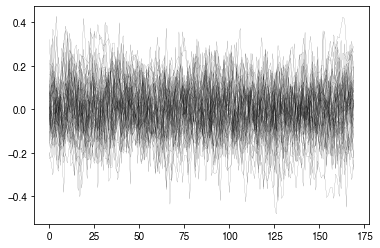

In [32]:
CMIP6_int_var_samples_nondeg.plot(legend=None,lw=0.1,c='k')

In [33]:
ant_coefs_iv = np.empty((CMIP6_int_var_samples_nondeg.columns.size,temp_ant.shape[1]))
nat_coefs_iv = np.empty((CMIP6_int_var_samples_nondeg.columns.size,temp_nat.shape[1]))

for i in tqdm.tqdm(np.arange(ant_coefs_iv.shape[1])):
    _lreg_coefs = OLSE_NORM(np.array([temp_ant.iloc[100:,i].values,temp_nat.iloc[100:,i].values]).T,CMIP6_int_var_samples_nondeg.values[:168])['coefs']
    ant_coefs_iv[:,i] = _lreg_coefs[0]
    nat_coefs_iv[:,i] = _lreg_coefs[1]
#     ant_coefs_iv.iloc[:,i] = _lreg_coefs[0]
#     nat_coefs_iv.iloc[:,i] = _lreg_coefs[1]

100%|██████████| 72000/72000 [02:14<00:00, 534.95it/s]


In [35]:
chosen_year = 2014

temp_ant_arr = (temp_ant.loc[chosen_year]-temp_ant.loc[1861:1880].mean()).values.reshape(N,18)
rate_ant_arr = OLSE_NORM(np.arange(5)[:,np.newaxis],temp_ant.loc[np.arange(chosen_year-4,chosen_year+1)].values)['coefs'].reshape(N,18)

temp_nat_arr = (temp_nat.loc[chosen_year]-temp_nat.loc[1861:1880].mean()).values.reshape(N,18)
rate_nat_arr = OLSE_NORM(np.arange(5)[:,np.newaxis],temp_nat.loc[np.arange(chosen_year-4,chosen_year+1)].values)['coefs'].reshape(N,18)

In [36]:
temp_attr_ant = (ant_coefs.reshape(-1,N,18)*temp_ant_arr)[:,None,...] + (ant_coefs_iv.reshape(-1,N,18)*temp_ant_arr)[None,...]
temp_attr_nat = (nat_coefs.reshape(-1,N,18)*temp_nat_arr)[:,None,...] + (nat_coefs_iv.reshape(-1,N,18)*temp_nat_arr)[None,...]

temp_rate_attr_ant = (ant_coefs.reshape(-1,N,18)*rate_ant_arr)[:,None,...] + (ant_coefs_iv.reshape(-1,N,18)*rate_ant_arr)[None,...]
temp_rate_attr_nat = (nat_coefs.reshape(-1,N,18)*rate_nat_arr)[:,None,...] + (nat_coefs_iv.reshape(-1,N,18)*rate_nat_arr)[None,...]

In [37]:
# print('Anthro Temp statistics')
# print(temp_attr_ant.describe(percentiles=[.05,.16,.33,.5,.66,.84,.95]).T)

# print('\nAnthro Temp rate statistics')
# print(temp_rate_attr_ant.describe(percentiles=[.05,.16,.33,.5,.66,.84,.95]).T)

# print('\nTotal Temp statistics')
# print((temp_attr_ant+temp_attr_nat).describe(percentiles=[.05,.16,.33,.5,.66,.84,.95]).T)

# print('\nTotal Temp rate statistics')
# print((temp_rate_attr_ant+temp_rate_attr_nat).describe(percentiles=[.05,.16,.33,.5,.66,.84,.95]).T)

HIGH_constrain_level,LOW_constrain_level = np.quantile(temp_attr_ant+temp_attr_nat,[0.95,0.05])
HIGH_constrain_rate,LOW_constrain_rate = np.quantile(temp_rate_attr_ant+temp_rate_attr_nat,[0.95,0.05])

print('Temp level constraint:')
print(LOW_constrain_level,HIGH_constrain_level)

print('\nTemp rate constraint:')
print(LOW_constrain_rate,HIGH_constrain_rate)

Temp level constraint:
0.7492012584928995 1.2585341862359873

Temp rate constraint:
0.018434972425118115 0.0398729161876676


In [39]:
print(np.quantile(temp_attr_ant+temp_attr_nat,[0.05,0.17,0.5,0.83,0.95]))
print(np.quantile(temp_rate_attr_ant+temp_rate_attr_nat,[0.05,0.17,0.5,0.83,0.95]))

[0.74920126 0.94811298 1.05862201 1.17135765 1.25853419]
[0.01843497 0.02195144 0.02730711 0.03409353 0.03987292]


Text(0, 0.5, 'rate of temperature change over 2010-2014 / K decade$^{-1}$')

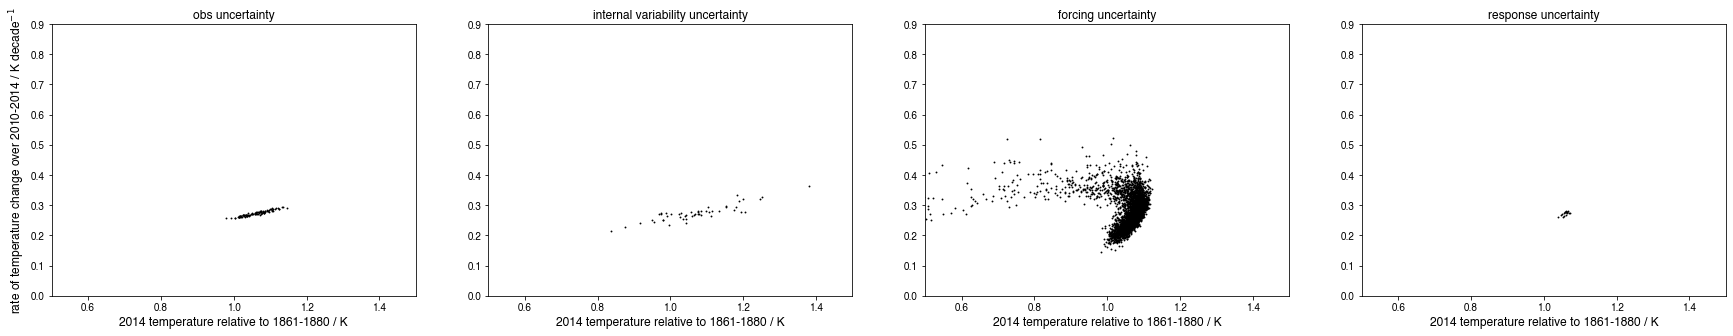

In [38]:
fig,ax=plt.subplots(1,4,figsize=(30,5))
# ax[0].hist2d((temp_attr_ant_and_iv+temp_attr_nat_and_iv).flatten(),10*(temp_rate_attr_ant_and_iv+temp_rate_attr_nat_and_iv).flatten(),bins=500,cmap='binary',density=True)

for i,source in enumerate(['obs','internal variability','forcing','response']):
    ax[i].scatter(np.median(temp_attr_ant+temp_attr_nat,axis=(np.arange(1,4)+i)%4),10*np.median(temp_rate_attr_ant+temp_rate_attr_nat,axis=(np.arange(1,4)+i)%4),color='k',marker='.',s=3)
    ax[i].set_title(source+' uncertainty')
    
[a.set_xlim(0.5,1.5) for a in ax]
[a.set_ylim(0.0,0.9) for a in ax]
[a.set_xlabel('2014 temperature relative to 1861-1880 / K',fontsize=12) for a in ax]
ax[0].set_ylabel('rate of temperature change over 2010-2014 / K decade$^{-1}$',fontsize=12)
# ax[0].set_title('FULL uncertainty',fontsize=12)

## Part II: constraining a large parameter ensemble

In [2]:
## start from here if you don't want to re-run the GWI:
baseline = [1861,1880]
chosen_year = 2014
HIGH_constrain_level,LOW_constrain_level = [1.2585341862359873 , 0.7492012584928995]
HIGH_constrain_rate,LOW_constrain_rate = [0.0398729161876676 , 0.018434972425118115]

#### Forcing parameter uncertainties
We construct ensembles of the ERF parameters used in the model by scaling each default ERF parameter by a scaling factor sampled from the appropriate distribution:
- CO$_2$ ~ $\mathcal{N}\left(1,\frac{0.2}{\Phi^{-1}(0.95)}\right)$
- CH$_4$ ~ $\mathcal{N}\left(1,\frac{0.28}{\Phi^{-1}(0.95)}\right)$
- N$_2$O ~ $\mathcal{N}\left(1,\frac{0.2}{\Phi^{-1}(0.95)}\right)$
- other WMGHGs ~ $\mathcal{N}\left(1,\frac{0.2}{\Phi^{-1}(0.95)}\right)$
- tropospheric O$_3$ ~ $\mathcal{N}\left(1,\frac{0.5}{\Phi^{-1}(0.95)}\right)$
- stratospheric O$_3$ ~ $\mathcal{N}\left(1,\frac{2}{\Phi^{-1}(0.95)}\right)$
- stratospheric H$_2$O from CH$_4$ ~ $\mathcal{N}\left(1,\frac{0.72}{\Phi^{-1}(0.95)}\right)$
- BC on snow ~ lognormal with quantiles 0.05 = 0.5 and 0.95 = 2.25
- contrails ~ $\mathcal{N}\left(1,\frac{0.75}{\Phi^{-1}(0.95)}\right)$
- ERFari ~ $\alpha$ parameters drawn from CMIP6 inferred multivariate normal; resulting distribution scaled to match process based assessment in Bellouin (2020)
- ERFaci ~ parameters drawn independently from CMIP6 inferred distribution; resulting distribtuion scaled to match process based assessment Bellouin (2020)
- LUC ~ $\mathcal{N}\left(1,\frac{0.75}{\Phi^{-1}(0.95)}\right)$
- volcanic ~ $\mathcal{N}\left(1,\frac{0.5}{\Phi^{-1}(0.95)}\right)$
- solar ~ $\mathcal{N}\left(1,\frac{1}{\Phi^{-1}(0.95)}\right)$

N.B. the numerator in each normal distribution scale parameter gives the half the 90% confidence interval (ie. uncertainty in CO$_2$ ERF is $\pm20\%$).

In [3]:
## create parameter ensemble

### do we go for sampling gaussian forcings / non-gaussian forcings / carbon-cycle parameters / response parameters independently
### and assuming all uncertainties within these categories are correlated?

default_params = pd.read_csv('../Parameter_Sets/Complete_gas_cycle_params.csv',skiprows=1,index_col=0)
forcing_namelist = list(default_params.columns)

param_categories = {}
param_categories['other_wmghgs'] = ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8','carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methyl_bromide', 'methyl_chloride', 'nf3', 'sf6', 'so2f2', 'halon1202']
param_categories['carbon_dioxide'] = ['carbon_dioxide']
param_categories['methane'] = ['methane']
param_categories['nitrous_oxide'] = ['nitrous_oxide']
param_categories['trop_o3'] = [x for x in forcing_namelist if '|trop_o3' in x]
param_categories['strat_o3'] = [x for x in forcing_namelist if '|strat_o3' in x]
param_categories['strat_h2o'] = [x for x in forcing_namelist if '|strat_h2o' in x]
param_categories['ari'] = ['so2', 'nox', 'co', 'nmvoc', 'bc', 'nh3','oc','nox_avi']
param_categories['aci'] = ['so2|aci','oc|aci','bc|aci']
param_categories['bc_on_snow'] = ['bc|bc_on_snow']
param_categories['contrails'] = ['nox_avi|contrails']

def get_forcing_param_ensemble(N,mem_names = False):
    
    if mem_names is False:
        mem_names = ['mem'+str(x) for x in np.arange(N)]
    
    category_distributions = pd.Series(index = param_categories.keys(),dtype=object)

    category_distributions.loc['carbon_dioxide'] = sp.stats.norm(1,0.20/1.645)
    category_distributions.loc['methane'] = sp.stats.norm(1,0.28/1.645)
    category_distributions.loc['nitrous_oxide'] = sp.stats.norm(1,0.2/1.645)
    category_distributions.loc['other_wmghgs'] = sp.stats.norm(1,0.20/1.645)
    category_distributions.loc['trop_o3'] = sp.stats.norm(1,0.5/1.645)
    category_distributions.loc['strat_o3'] = sp.stats.norm(1,2/1.645)
    category_distributions.loc['strat_h2o'] = sp.stats.norm(1,0.72/1.645)
    pct_5 = 0.04 / 0.08 # need to scale by the mean to turn into a "scaling factor"
    pct_95=0.18 / 0.08
    sigma = (np.log(pct_95) - np.log(pct_5)) / (sp.stats.norm().ppf(0.95)-sp.stats.norm().ppf(0.05))
    mu = np.log(pct_5) - sigma * sp.stats.norm().ppf(0.05)
    category_distributions.loc['bc_on_snow'] = sp.stats.lognorm(s=sigma,scale=np.exp(mu))
    category_distributions.loc['contrails'] = sp.stats.norm(1,0.75/1.645)

    f_parameter_ensemble_draw = np.zeros((3,len(forcing_namelist),N))
    default_f_params = default_params.loc['f1':'f3'].values

    for key in category_distributions.index:
        if not type(category_distributions.loc[key]) == sp.stats._distn_infrastructure.rv_frozen:
            continue
        cat_map = [x in param_categories[key] for x in forcing_namelist]
        f_parameter_ensemble_draw[:,cat_map,:] = default_f_params[:,cat_map,None] * category_distributions.loc[key].rvs(N)[None,None]
        
    ## draw aerosol parameters based on inferred CMIP6 ranges (see CMIP6_parameter_ranges notebook), then rescaled to match the Bellouin process based assessment

    ## compute parameters, then scale by the Bellouin / 1850-(2005:2015)
    
    ERFari_params = pd.read_csv('../Parameter_Sets/CMIP6_ERFari.csv',index_col=0)
    
    ERFari_mean = ERFari_params.mean().values
    ERFari_cov = ERFari_params.cov().values

    ERFari_param_draw = sp.stats.multivariate_normal(ERFari_mean,ERFari_cov).rvs(N)
    
    ERFaci_params = pd.read_csv('../Parameter_Sets/CMIP6_ERFaci.csv',index_col=0)
    
    ERFaci_ln_beta_s_cov = ERFaci_params[['log_beta','log_beta_s']].cov().values
    ERFaci_ln_beta_s_mean = ERFaci_params[['log_beta','log_beta_s']].mean().values
    ERFaci_alpha_mean = ERFaci_params['alpha'].mean()
    ERFaci_alpha_std = ERFaci_params['alpha'].std()

    ERFaci_beta_s = np.exp(sp.stats.multivariate_normal(ERFaci_ln_beta_s_mean,ERFaci_ln_beta_s_cov).rvs(N))
    ERFaci_alpha = sp.stats.norm(ERFaci_alpha_mean,ERFaci_alpha_std).rvs(N)
    ERFaci_beta = -1*ERFaci_beta_s[...,0]
    ERFaci_s = ERFaci_beta_s[...,0] / ERFaci_beta_s[...,1]
    
    ## get aerosol emissions
    RCMIP_aer_emms = RCMIP_emms.loc[('World','ssp245',['Emissions|Sulfur','Emissions|OC','Emissions|BC'])].iloc[:,4:].droplevel((0,1)).apply(pd.to_numeric).T.interpolate().loc[:'2019']
    ## baseline to be zero in 1750
    RCMIP_aer_emms -= RCMIP_aer_emms.loc['1750']

    ## generate the 1850 - 2010 change
    ERFari_1850_2010 = ((RCMIP_aer_emms.loc['2005':'2010'].mean() - RCMIP_aer_emms.loc['1850']).values * ERFari_param_draw).sum(axis=1)

    ERFaci_1850_2010 = ERFaci_beta * ( np.log(1 + RCMIP_aer_emms.loc['2005':'2010','Emissions|Sulfur'].mean()/ERFaci_s) - np.log(1 + RCMIP_aer_emms.loc['1850','Emissions|Sulfur'].mean()/ERFaci_s) ) \
    + ERFaci_alpha * (RCMIP_aer_emms.loc['2005':'2010',['Emissions|OC','Emissions|BC']].mean().sum() - RCMIP_aer_emms.loc['1850',['Emissions|OC','Emissions|BC']].sum())
    
    # Use Nicolas' Ringberg methods
    def uniform1684(a,b,seed,samples=2000):
        interval = (b-a)+((b-a)/(84-16)*32)
        lower = a-((b-a)/(84-16)*16)
        return sp.stats.uniform.rvs(lower, interval, size=samples, random_state=seed)
    samples=N
    dtau    = uniform1684(0.02,0.04,123,samples=samples)
    tau     = uniform1684(0.13,0.17,124,samples=samples)
    S_tau   = uniform1684(-27,-20,125,samples=samples)
    RFari_cloudy = uniform1684(-0.1,0.1,126,samples=samples)
    dR_dRatm = uniform1684(-0.3,-0.1,127,samples=samples)
    dRatm_dtau = uniform1684(17,35,128,samples=samples)
    c_tau    = uniform1684(0.59,0.71,129,samples=samples)
    c_N      = uniform1684(0.19,0.29,130,samples=samples)
    c_L      = uniform1684(0.21,0.29,131,samples=samples)
    c_C      = uniform1684(0.59,1.07,132,samples=samples)
    beta_N_tau = uniform1684(0.3,0.8,133,samples=samples)
    beta_L_N   = uniform1684(-0.36,-0.011,134,samples=samples)
    beta_C_N   = uniform1684(0,0.1,135,samples=samples)
    S_N = uniform1684(-27,-26,136,samples=samples)
    S_L = uniform1684(-56,-54,137,samples=samples)
    S_C = uniform1684(-153,-91,138,samples=samples)

    rfari = dtau*S_tau*(1-c_tau)+RFari_cloudy
    rfari_adj = dtau*dR_dRatm*dRatm_dtau

    dlntau = dtau/tau
    deltan = dlntau * beta_N_tau

    rfaci = dlntau*beta_N_tau*S_N*c_N
    erfaci_L = dlntau*beta_N_tau*beta_L_N*S_L*c_L
    erfaci_C = dlntau*beta_N_tau*beta_C_N*S_C*c_C

    ERFari_scale = rfari + rfari_adj
    ERFaci_scale = rfaci + erfaci_L + erfaci_C
    
    def np_quantileatscore(a,score):
    
        return ( (a[:,np.newaxis,...]<score[np.newaxis,...]).sum(axis=0) + (a[:,np.newaxis,...]<=score[np.newaxis,...]).sum(axis=0) ) / (2*a.shape[0])

    ERFari_qmap = (ERFari_scale[np.argsort(ERFari_scale)][(np_quantileatscore(ERFari_1850_2010,ERFari_1850_2010)*N).astype(int)] / ERFari_1850_2010)
    ERFaci_qmap = (ERFaci_scale[np.argsort(ERFaci_scale)][(np_quantileatscore(ERFaci_1850_2010,ERFaci_1850_2010)*N).astype(int)] / ERFaci_1850_2010)
    
    for i,cat in enumerate(['bc','oc','so2']):
        cat_map = forcing_namelist.index(cat)
        f_parameter_ensemble_draw[1,cat_map,:] = ERFari_param_draw[...,i]*ERFari_qmap

    so2_PI_conc_ensemble = ERFaci_s.copy()

    cat_map = forcing_namelist.index('so2|aci')
    f_parameter_ensemble_draw[0,cat_map,:] = ERFaci_beta*ERFaci_qmap

    cat_map = forcing_namelist.index('oc|aci')
    f_parameter_ensemble_draw[1,cat_map,:] = ERFaci_alpha*ERFaci_qmap
    cat_map = forcing_namelist.index('bc|aci')
    f_parameter_ensemble_draw[1,cat_map,:] = ERFaci_alpha*ERFaci_qmap
    
    gas_parameter_ensemble = pd.concat([default_params.copy()]*N,axis=1,keys=mem_names)

    gas_parameter_ensemble.loc['f1':'f3',:] = f_parameter_ensemble_draw.swapaxes(1,2).reshape(3,-1)[:]

    gas_parameter_ensemble.loc['PI_conc',(slice(None),'so2')] = so2_PI_conc_ensemble[:]
    
    return gas_parameter_ensemble

#### Response parameter uncertainties

In [4]:
def get_response_params(N,gas_parameter_ensemble,mem_names = False):
    
    if mem_names is False:
        mem_names = ['mem'+str(x) for x in np.arange(N)]
    
    ## require gas_params for the F_2x value

    ## draw ln d1, ln d2, q1 | ln d3 | RWF | TCR

    # covariance of ln_d1, d2, q1
    cov_mat_1 = np.array([[0.95199915, 0.47649902, 0.09359745], [0.47649902, 0.59388914, 0.09119872], [0.09359745, 0.09119872, 0.01710808]])

    mean_mat_1 = np.array([-0.20227299,  2.05243353,  0.20285564])
    
    ln_d3_mean = 5.76338587
    ln_d3_std = 0.57722689
    
    # we alter the CMIP6 assessed ranges to cover a slighly wider range
    RWF_mean = 0.55 # 0.55124171
    RWF_std = 0.3/1.645 # 0.13777385
    
    TCR_mean = 2# 2.0782074
    TCR_std = 1/1.645# 0.45012178

    F_2x = gas_parameter_ensemble.loc['f1',(slice(None),'carbon_dioxide')].values * np.log(2) + gas_parameter_ensemble.loc['f3',(slice(None),'carbon_dioxide')].values * (np.sqrt(278*2) - np.sqrt(278))

    lnd1 , lnd2 , q1 , RWF , lnd3 , TCR , d1, d2, d3 , ECS , v1 , v2 , v3 , q2 , q3 = np.empty((15,N))

    neg_idx = np.ones(N).astype(bool)
    N_neg = neg_idx.sum()

    while N_neg>0:

        lnd1[neg_idx], lnd2[neg_idx], q1[neg_idx] = sp.stats.multivariate_normal(mean_mat_1,cov_mat_1).rvs(N_neg).T
        lnd3[neg_idx] = sp.stats.norm(ln_d3_mean, ln_d3_std).rvs(N_neg)
#         RWF[neg_idx] = sp.stats.truncnorm(-3,3,RWF_mean, 0.15).rvs(N_neg)
#         TCR[neg_idx] = sp.stats.truncnorm(-3,3,TCR_mean, TCR_std).rvs(N_neg)
        RWF[neg_idx] = sp.stats.uniform(0.2,0.65).rvs(N_neg)
        TCR[neg_idx] = sp.stats.uniform(0.5,3).rvs(N_neg)
        d1[neg_idx] = np.exp(lnd1[neg_idx])
        d2[neg_idx] = np.exp(lnd2[neg_idx])
        d3[neg_idx] = np.exp(lnd3[neg_idx])
        ECS[neg_idx] = TCR[neg_idx]/RWF[neg_idx]

        v1[neg_idx] = (1-(d1/69.66) * (1-np.exp(-69.66/d1)) )[neg_idx]
        v2[neg_idx] = (1-(d2/69.66) * (1-np.exp(-69.66/d2)) )[neg_idx]
        v3[neg_idx] = (1-(d3/69.66) * (1-np.exp(-69.66/d3)) )[neg_idx]

        q3[neg_idx] = (((TCR/F_2x) - q1*(v1-v2) - (ECS/F_2x)*v2) / (v3-v2))[neg_idx]
        q2[neg_idx] = (ECS/F_2x - q1 -  q3)[neg_idx]

        neg_idx = np.any(np.array([d1,d2,d3,q1,q2,q3])<0,axis=0)
        N_neg = neg_idx.sum()

    response_par_ensemble = np.array([d1,d2,d3,q1,q2,q3]).T
    thermal_parameter_ensemble = pd.concat([get_thermal_parameter_defaults()['default'].copy()]*N,axis=1,keys=mem_names)
    thermal_parameter_ensemble.loc[:] = response_par_ensemble.reshape(N,2,3).swapaxes(0,1).reshape(2,-1)
    
    return thermal_parameter_ensemble

We run in chunks of 10,000 at a time to reduce the RAM consumption

In [5]:
def run_CONSTRAIN(N,ssp='ssp245',mem_names=False):
    
    if mem_names is False:
        mem_names = ['mem'+str(x) for x in np.arange(N)]
    
    # forcing uncertainty
    ## anothropogenic
    gas_parameter_ensemble = get_forcing_param_ensemble(10000,mem_names=mem_names)
    
    erf_ar6 = pd.read_csv('https://raw.githubusercontent.com/Priestley-Centre/ssp_erf/master/SSPs/ERF_'+ssp+'_1750-2500.csv',index_col=0,dtype=float)
    ## LUC
    LUC_forc = erf_ar6[['land_use']].reindex(np.arange(1750,2101)).values
    LUC_forc_sfs = sp.stats.norm(1,0.75/1.645).rvs(N)
    LUC_forc_ensemble = LUC_forc_sfs[None] * LUC_forc
    
    ## Natural
    volc_forc = erf_ar6[['volcanic']].reindex(np.arange(1750,2101)).values
    volc_forc_sfs = sp.stats.norm(1,0.5/1.645).rvs(N)
    volc_forc_ensemble = volc_forc_sfs[None] * volc_forc
    sol_forc = erf_ar6[['solar']].reindex(np.arange(1750,2101)).values
    sol_forc_sfs = sp.stats.norm(1,1/1.645).rvs(N)
    sol_forc_ensemble = sol_forc_sfs[None] * sol_forc
    
    ext_forc_sfs = pd.DataFrame([LUC_forc_sfs,volc_forc_sfs,sol_forc_sfs],index=['LUC','volc','sol'],columns = mem_names)
    
    ssp_forc = pd.DataFrame(LUC_forc_ensemble+sol_forc_ensemble+volc_forc_ensemble,index=np.arange(1750,2101),columns=pd.MultiIndex.from_product([mem_names,['forcing']]) )
    
    # carbon cycle uncertainty
#     cc_uncertainty = 0.13 / 1.645 * (4.165 / 3.587)
#     cc_param_draw = sp.stats.norm(1,cc_uncertainty).rvs(N).reshape(1,-1)
#     gas_parameter_ensemble.loc['r0':'rT',(slice(None),'carbon_dioxide')] = gas_parameter_ensemble.loc['r0':'rT',(slice(None),'carbon_dioxide')].values * cc_param_draw
    cc_params = pd.read_csv('../Parameter_Sets/CMIP6_1pctCO2_cc_200820_byOLSE.csv',index_col=0).astype(float)
    r0_draw = sp.stats.norm(1,cc_params.r0.std()/cc_params.r0.mean()).rvs(N)
    rC_draw = np.exp(sp.stats.norm(np.log(1),abs(np.log(cc_params.rC).std()/np.log(cc_params.rC).mean())).rvs(N))
    rT_draw = sp.stats.norm(1,cc_params.rT.std()/cc_params.rT.mean()).rvs(N)
    gas_parameter_ensemble.loc['r0':'rT',(slice(None),'carbon_dioxide')] = gas_parameter_ensemble.loc['r0':'rT',(slice(None),'carbon_dioxide')].values * np.array([r0_draw,rC_draw,rT_draw])
    
    # response uncertainty
    thermal_parameter_ensemble = get_response_params(10000,gas_parameter_ensemble,mem_names)
    
    # get ssp emissions
    ssp_emms = RCMIP_to_GIR_input_emms(ssp).interpolate().reindex(np.arange(1750,2101))
    ssp_emms -= ssp_emms.loc[1750] # emissions relative to 1750 values
    sf = GCP_historical_emissions.sum(axis=1).loc[2015] / ssp_emms.loc[2015,'carbon_dioxide']
    ssp_emms.loc[:2014,'carbon_dioxide'] = GCP_historical_emissions.sum(axis=1).loc[1750:2014]
    ssp_emms.loc[2015:2025,'carbon_dioxide'] *= np.linspace(sf,1,11)
    ssp_emms = pd.concat([ssp_emms]*N,axis=1,keys=mem_names)
    # switch in GCP for CO2
    
    # run the model
    FULL = run_GIR(emissions_in=ssp_emms,forcing_in=ssp_forc,gas_parameters=gas_parameter_ensemble,thermal_parameters=thermal_parameter_ensemble,show_run_info=False)
    
    # get the constraints:
    temp_constraint = ((FULL['T'].loc[chosen_year]-FULL['T'].loc[baseline[0]:baseline[1]].mean())<HIGH_constrain_level)&((FULL['T'].loc[chosen_year]-FULL['T'].loc[baseline[0]:baseline[1]].mean())>LOW_constrain_level)
    rate_constraint = (FULL['T'].diff(5).loc[chosen_year]/5<HIGH_constrain_rate)&(FULL['T'].diff(5).loc[chosen_year]/5>LOW_constrain_rate)
    
    _output = pd.DataFrame(index=['ECS','TCR'],columns=FULL['T'].columns.levels[-1])

    f = gas_parameter_ensemble.loc['f1':'f3',(slice(None),'carbon_dioxide')].values
    F_2x = f[0]*np.log(2)+f[2]*(np.sqrt(278*2)-np.sqrt(278))
    _output.loc['ECS',:] = F_2x*thermal_parameter_ensemble.loc['q'].values.reshape(-1,3).sum(axis=1)
    _output.loc['TCR',:] = F_2x * ( thermal_parameter_ensemble.loc['q'].values.reshape(-1,3) * (1 - (thermal_parameter_ensemble.loc['d'].values.reshape(-1,3)/69.66) * ( 1 - np.exp(-69.66/thermal_parameter_ensemble.loc['d'].values.reshape(-1,3)) ) ) ).sum(axis=1)
        
    _output.loc['T_2100',:] = (FULL['T'].loc[2100]-FULL['T'].loc[1861:1880].mean()).reset_index(level=0).set_index('Scenario').iloc[:,0]
    _output.loc['T_EoC',:] = (FULL['T'].loc[2081:2100].mean()-FULL['T'].loc[1861:1880].mean()).reset_index(level=0).set_index('Scenario').iloc[:,0]
    _output.loc['T_2014',:] = (FULL['T'].loc[2014]-FULL['T'].loc[1861:1880].mean()).reset_index(level=0).set_index('Scenario').iloc[:,0]
    _output.loc['T_10s',:] = (FULL['T'].loc[2010:2019].mean()-FULL['T'].loc[1861:1880].mean()).reset_index(level=0).set_index('Scenario').iloc[:,0]
    
    for forc_cat in param_categories.keys():

        _output.loc[forc_cat+'_2019',:] = FULL['RF'].loc[2019,(slice(None),param_categories[forc_cat])].groupby(level=0).sum()
        _output.loc[forc_cat+'_2100',:] = FULL['RF'].loc[2100,(slice(None),param_categories[forc_cat])].groupby(level=0).sum()

    _output.loc['LUC_2019',:] = LUC_forc_sfs * erf_ar6.loc[2019,'land_use']
    _output.loc['LUC_2100',:] = LUC_forc_sfs * erf_ar6.loc[2100,'land_use']

    _output.loc['GHG_2019',:] = _output.loc[[x+'_2019' for x in ['other_wmghgs', 'carbon_dioxide', 'methane', 'nitrous_oxide', 'trop_o3', 'strat_o3', 'strat_h2o']]].sum()
    _output.loc['GHG_2100',:] = _output.loc[[x+'_2100' for x in ['other_wmghgs', 'carbon_dioxide', 'methane', 'nitrous_oxide', 'trop_o3', 'strat_o3', 'strat_h2o']]].sum()
    _output.loc['aer_2019',:] = _output.loc[[x+'_2019' for x in ['aci','ari']]].sum()
    _output.loc['aer_2100',:] = _output.loc[[x+'_2100' for x in ['aci','ari']]].sum()
    _output.loc['anthro_2019',:] = _output.loc[[x+'_2019' for x in param_categories.keys()]+['LUC_2019']].sum()
    _output.loc['anthro_2100',:] = _output.loc[[x+'_2100' for x in param_categories.keys()]+['LUC_2100']].sum()
    
    _output.loc['constrain_level',:] = temp_constraint.reset_index(level=0).set_index('Scenario').iloc[:,0]
    _output.loc['constrain_rate',:] = rate_constraint.reset_index(level=0).set_index('Scenario').iloc[:,0]
    _output.loc['constrain_multi',:] = (temp_constraint&rate_constraint).reset_index(level=0).set_index('Scenario').iloc[:,0]
    
    gas_parameter_ensemble.to_pickle('../Parameter_Sets/NROY/gas_params_'+mem_names[0]+'-'+mem_names[-1]+'_altprior.pkl')
    thermal_parameter_ensemble.to_pickle('../Parameter_Sets/NROY/response_params_'+mem_names[0]+'-'+mem_names[-1]+'_altprior.pkl')
    temp_constraint.to_pickle('../Parameter_Sets/NROY/temp_constraint_'+mem_names[0]+'-'+mem_names[-1]+'_altprior.pkl')
    rate_constraint.to_pickle('../Parameter_Sets/NROY/rate_constraint_'+mem_names[0]+'-'+mem_names[-1]+'_altprior.pkl')
    ext_forc_sfs.to_pickle('../Parameter_Sets/NROY/EXT_forc_'+mem_names[0]+'-'+mem_names[-1]+'_altprior.pkl')
    
    return _output

In [6]:
## run a total of 1,000,000 ensembles:
results = []
for i in np.arange(100):
    results+=[run_CONSTRAIN(10000,mem_names=['mem'+str(x) for x in np.arange(10000*(i),10000*(i+1))])]

100%|██████████| 350/350 [00:26<00:00, 13.29 timestep/s]


In [7]:
ALTERNATIVE = pd.concat(results,axis=1).apply(pd.to_numeric).dropna(axis=1)

In [9]:
ALTERNATIVE.to_hdf(r'/home/leachl/Documents/Simple_models/FaIR_v2-0_paper/NROY_results/ALTERNATIVE_v1.h5', key='stage', mode='w')

In [7]:
# FULL_results = pd.concat(results,axis=1).apply(pd.to_numeric).dropna(axis=1)

In [ ]:
# FULL_results.to_csv('/home/leachl/Documents/Simple_models/FaIR_v2-0_paper/NROY_results/FULL.csv')

## Analysis of output

In [2]:
ssp_data = []
for ssp in [x for x in RCMIP_emms.index.levels[1].unique() if 'ssp' in x]:
    ssp_data += [pd.read_hdf('/home/leachl/Documents/Simple_models/FaIR_v2-0_paper/NROY_results/'+ssp+'.h5')]
    
ssp_data = pd.concat(ssp_data,axis=1,keys=[x for x in RCMIP_emms.index.levels[1].unique() if 'ssp' in x])

In [3]:
FULL_results = pd.read_hdf('/home/leachl/Documents/Simple_models/FaIR_v2-0_paper/NROY_results/FULL_v1.h5')

In [4]:
## obtain some cmip6 parameter ranges for tas / ECS / TCR / aer_2019

## get the actual historical / ssp data:
ssp_tas = pd.read_csv('../tools/cmip6_data/ssp_tas.csv',index_col=0)
hist_tas = pd.read_csv('../tools/cmip6_data/hist_tas.csv',index_col=0).iloc[1:]

for i,x in enumerate(['source','member','variable','experiment']):
    ssp_tas.loc[x] = [x.split('_')[i+1] for x in ssp_tas.columns]
for i,x in enumerate(['source','member']):    
    hist_tas.loc[x] = [x.split('_')[i+1] for x in hist_tas.columns]
    

ssp_tas=ssp_tas.T.set_index(['source','member','experiment']).T.drop('variable').apply(pd.to_numeric)
hist_tas=hist_tas.T.set_index(['source','member']).T.apply(pd.to_numeric)
ssp_tas['year']=[int(x) for x in ssp_tas.index]
ssp_tas = ssp_tas.set_index('year')
ssp_tas = ssp_tas.reindex(np.arange(1850,2301))

hist_tas['year']=[int(x) for x in hist_tas.index]
hist_tas = hist_tas.set_index('year')

for modmem in hist_tas.columns:
    if modmem in ssp_tas.columns.droplevel(-1):
        for exp in ssp_tas.loc[1850:2014,modmem].columns:
            ssp_tas.loc[1850:2014,(*modmem,exp)] = hist_tas.loc[1850:2014,modmem]
            
## response params
CMIP6_response_params = pd.read_csv('../Parameter_Sets/CMIP6_stoch_Geoffrey_response.csv',index_col=0)

def BuildMat(params):
#     param_names = ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx','F_2x']
    A = np.array([[-1*params[0],0,0,0],\
                     [1/params[1],-1*(params[4]+params[5])/params[1],params[5]/params[1],0],\
                     [0,params[5]/params[2],-1*(params[5]+params[7]*params[6])/params[2],params[7]*params[6]/params[2]],\
                     [0,0,params[6]/params[3],-1*params[6]/params[3]]])
    k = A.shape[0]
    b = np.array([params[0],0,0,0]).T
    Q = np.zeros((4,4))
    Q[0,0] = params[8]**2
    Q[1,1] = (params[9]/params[1])**2
    A_d = sp.linalg.expm(A)
    b_d = sp.linalg.solve(A, (A_d - np.identity(k)) @ b)
    ## use Van Loan (1978) to compute the matrix exponential
    H = np.zeros((k*2,k*2))
    H[:k,:k] = -A
    H[:k,k:] = Q
    H[k:,k:] = A.T
    G = sp.linalg.expm(H)
    Q_d = G[k:,k:].T @ G[:k,k:]
    C_d = np.array([[0,1,0,0],\
                   [1,-1*params[4],(1-params[7])*params[6],-1*(1-params[7])*params[6]]])
    
    return A,b,Q,A_d,b_d,Q_d,C_d

def convert_geoffrey_to_FaIR(params):
#     ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx','F_4x']

    A,b,Q,A_d,b_d,Q_d,C_d = BuildMat(params)
    eigval,eigvec = np.linalg.eig(A[1:,1:])
    tau = -1/eigval
    q = tau * ( eigvec[0,:] * np.linalg.inv(eigvec)[:,0] ) / params[1]
    
    order = np.argsort(tau)
    
    return pd.DataFrame([tau[order],q[order]],index=['d','q'],columns=[1,2,3])

CMIP6_response_params.loc['ECS'] = np.nan
CMIP6_response_params.loc['TCR'] = np.nan
for model in CMIP6_response_params.columns:
    fair_params = pd.concat([convert_geoffrey_to_FaIR(CMIP6_response_params.loc[:'F_4x',model].values)],axis=1,keys=[model])
    CMIP6_response_params.loc[['ECS','TCR'],model] = q_to_tcr_ecs(fair_params,F_2x = CMIP6_response_params.loc['F_2x',model]).iloc[:,0]
CMIP6_response_params.loc['RWF'] = CMIP6_response_params.loc['TCR'] / CMIP6_response_params.loc['ECS']


# ERFari/aci: APRP data very noisy so we use the emissions based fits:
ERFari_params = pd.read_csv('../Parameter_Sets/CMIP6_ERFari.csv',index_col=0)
ERFaci_params = pd.read_csv('../Parameter_Sets/CMIP6_ERFaci.csv',index_col=0)

ssp_emms = RCMIP_to_GIR_input_emms('ssp245').interpolate().reindex(np.arange(1750,2101))
ssp_emms -= ssp_emms.loc[1750] # emissions relative to 1750 values

CMIP6_aer_forc_2019 = pd.DataFrame(index=ERFari_params.index,columns=['aci','ari','aer'])

for model in CMIP6_aer_forc_2019.index:
    CMIP6_aer_forc_2019.loc[model,'ari'] = ssp_emms.loc[2019,'so2']*ERFari_params.loc[model,'so2'] + ssp_emms.loc[2019,'bc']*ERFari_params.loc[model,'bc'] + ssp_emms.loc[2019,'oc']*ERFari_params.loc[model,'oc']
    CMIP6_aer_forc_2019.loc[model,'aci'] = ERFaci_params.loc[model,'beta'] * np.log(1+ssp_emms.loc[2019,'so2']/ERFaci_params.loc[model,'s']) + ERFaci_params.loc[model,'alpha']*(ssp_emms.loc[2019,'bc']+ssp_emms.loc[2019,'oc'])
    CMIP6_aer_forc_2019.loc[model,'aer'] = CMIP6_aer_forc_2019.loc[model,'aci'] + CMIP6_aer_forc_2019.loc[model,'ari']

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


In [5]:
baseline = [1861,1880]

plot_cmip6_tas2100 = ssp_tas.loc[:].xs('ssp245',axis=1,level=-1).drop(('KACE-1-0-G','r3i1p1f1'),axis=1).groupby(level=0,axis=1).mean()
plot_cmip6_tas2100 = plot_cmip6_tas2100 - plot_cmip6_tas2100.loc[baseline[0]:baseline[1]].mean()

In [6]:
# ssp_tas.loc[:,ssp_tas.loc[1850]<280]
# CMIP6_response_params.loc[['ECS','TCR']].T

In [7]:
def custom_kde(x,y):
    
    ## first remove the FAR outliers (5-sigma) from x and y in turn
    
    x_rank = np.argsort(x)
    x = x[x_rank]
    y = y[x_rank]
    num_outlier_high = -1*(x>(x.mean()+5.2*x.std())).sum()
    num_outlier_low = (x<(x.mean()-5.2*x.std())).sum()
    if not num_outlier_high:
        num_outlier_high = None
    if not num_outlier_low:
        num_outlier_low = None
    x = x[num_outlier_low:num_outlier_high]
    y = y[num_outlier_low:num_outlier_high]


    y_rank = np.argsort(y)
    x = x[y_rank]
    y = y[y_rank]
    num_outlier_high = -1*(y>(y.mean()+5.2*y.std())).sum()
    num_outlier_low = (y<(y.mean()-5.2*y.std())).sum()
    if not num_outlier_high:
        num_outlier_high = None
    if not num_outlier_low:
        num_outlier_low = None
    x = x[num_outlier_low:num_outlier_high]
    y = y[num_outlier_low:num_outlier_high]
    
    gridsize=100
    k = sp.stats.kde.gaussian_kde([x,y])
    xi,yi = np.mgrid[x.min()-0.5:x.max()+0.5:gridsize*1j,y.min()-0.5:y.max()+0.5:gridsize*1j]
    zi = k(np.vstack([xi.flatten(),yi.flatten()])).reshape(xi.shape)
    dens_vals = np.linspace(0,zi.max(),gridsize)
    zi_int = ((zi>=dens_vals[:,None,None])*zi).sum(axis=(1,2))/zi.sum()
    zi_int_to_dens = sp.interpolate.interp1d(zi_int,dens_vals)
    dens_contours = zi_int_to_dens([0.95,0.67,0.33,0.05])
    
    return xi,yi,zi,dens_contours

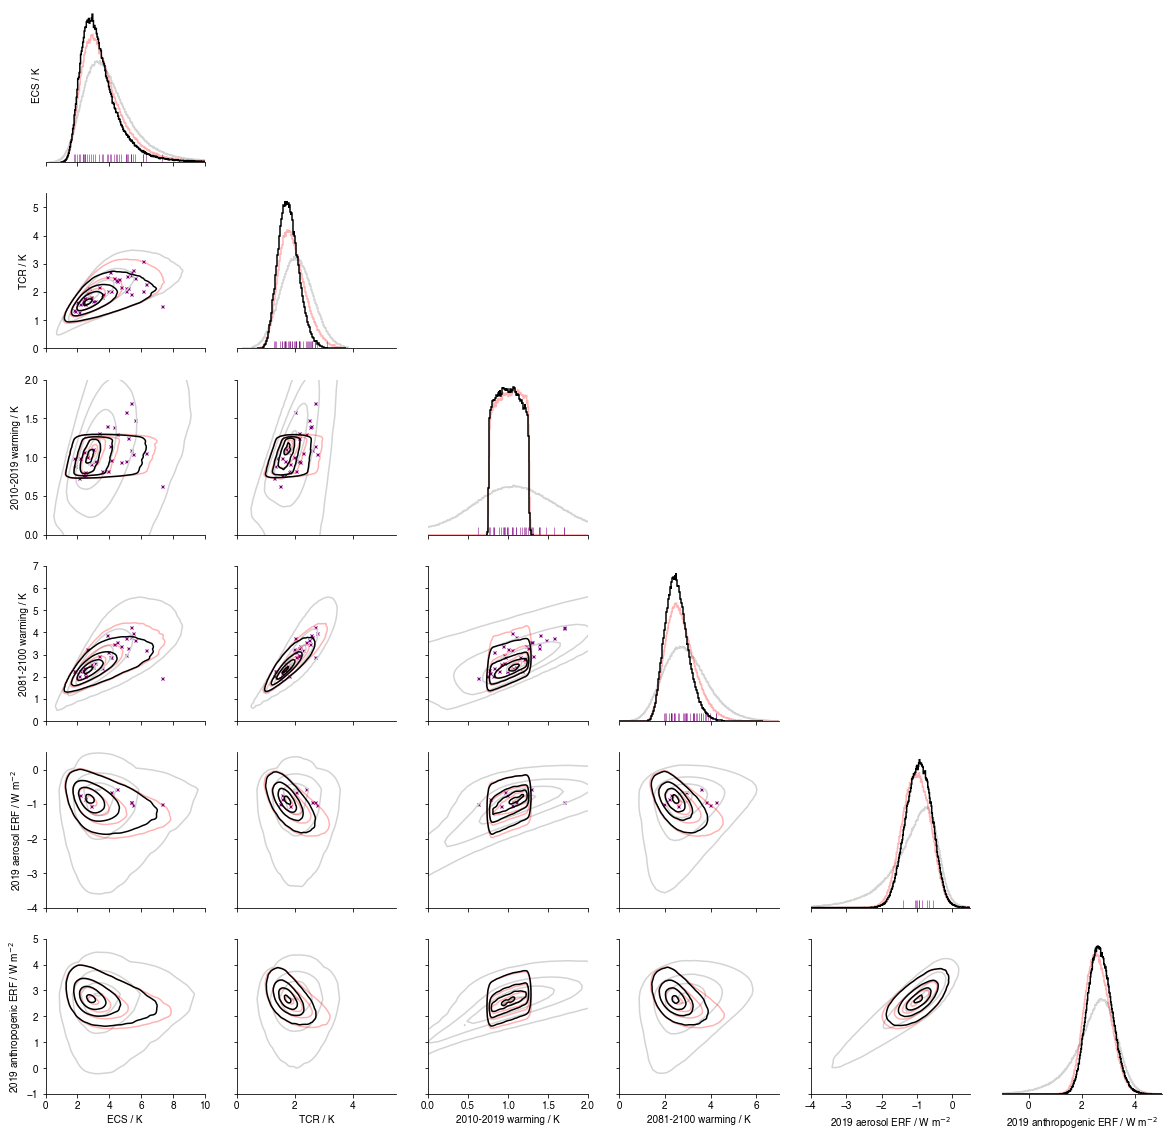

In [29]:
## create a correlation matrix plot:

cor_vars = ['ECS','TCR','T_10s','T_EoC','aer_2019','anthro_2019']

map_cor_vars = dict(zip(cor_vars,['ECS / K','TCR / K','2010-2019 warming / K','2081-2100 warming / K','2019 aerosol ERF / W m$^{-2}$','2019 anthropogenic ERF / W m$^{-2}$']))

fig,ax = plt.subplots(len(cor_vars),len(cor_vars),figsize=(20,20))

[ax[i,j].set_visible(False) for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if j>i]

## plot the distributions:

for i in np.arange(len(cor_vars)):
    ax[i,i].hist(FULL_results.loc[cor_vars[i]].values.flatten(),histtype='step',color='lightgrey',density=True,lw=1.5)
    ax[i,i].hist(FULL_results.loc[cor_vars[i],FULL_results.loc['constrain_level'].astype(bool)].values.flatten(),histtype='step',color='red',density=True,lw=1.5,alpha=0.3)
    ax[i,i].hist(FULL_results.loc[cor_vars[i],FULL_results.loc['constrain_multi'].astype(bool)].values.flatten(),histtype='step',color='k',density=True,lw=1.5)
    
    
## do some kde plots
import multiprocessing
def kde_wrapper(i,j,constrain):
    if constrain:
        result = custom_kde(FULL_results.loc[cor_vars[j],FULL_results.loc[constrain].astype(bool)].values.flatten(),FULL_results.loc[cor_vars[i],FULL_results.loc[constrain].astype(bool)].values.flatten())
    else:
        result = custom_kde(FULL_results.loc[cor_vars[j]].values.flatten(),FULL_results.loc[cor_vars[i]].values.flatten())
        
    return result
        
# derive the kdes:
        
# P1=multiprocessing.Pool(processes=4)
plot_indices = [[i,j,False] for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if j<i]
# kde_FULL = P1.starmap(kde_wrapper,plot_indices)
# plot_indices = [[i,j,'constrain_level'] for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if j<i]
# kde_level = P1.starmap(kde_wrapper,plot_indices)
# plot_indices = [[i,j,'constrain_multi'] for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if j<i]
# kde_constrain = P1.starmap(kde_wrapper,plot_indices)
# P1.close()

# plot the kdes:
[ax[x[0],x[1]].contour(kde_FULL[i][0],kde_FULL[i][1],kde_FULL[i][2],kde_FULL[i][3],colors='lightgrey') for i,x in enumerate(plot_indices)]
[ax[x[0],x[1]].contour(kde_level[i][0],kde_level[i][1],kde_level[i][2],kde_level[i][3],colors='red',alpha=0.3) for i,x in enumerate(plot_indices)]
[ax[x[0],x[1]].contour(kde_constrain[i][0],kde_constrain[i][1],kde_constrain[i][2],kde_constrain[i][3],colors='k') for i,x in enumerate(plot_indices)]

# plot CMIP6 samples:
cmip6_samples = [CMIP6_response_params.loc['ECS'],CMIP6_response_params.loc['TCR'],plot_cmip6_tas2100.loc[2010:2019].mean(),plot_cmip6_tas2100.loc[2081:2100].mean(),CMIP6_aer_forc_2019.aer]
for i in np.arange(5):
    for j in np.arange(5):
        if j<i:
            intersection = list(set(cmip6_samples[i].index).intersection(set(cmip6_samples[j].index)))
            ax[i,j].plot(cmip6_samples[j].loc[intersection],cmip6_samples[i].loc[intersection],'x',color='purple',ms=3,zorder=0)

axes_lims = [[0,10],[0,5.5],[0,2],[0,7],[-4,0.5],[-1,5]]

[sn.rugplot(cmip6_samples[i],ax=ax[i,i],color='purple',lw=0.5) for i in np.arange(5)]

[ax[i,j].set_xlim(axes_lims[j]) for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars))]
[ax[i,j].set_ylim(axes_lims[i]) for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if j<i]
[ax[i,j].set_ylabel(map_cor_vars[cor_vars[i]]) for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if j==0]
[ax[i,j].set_xlabel(map_cor_vars[cor_vars[j]]) for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if i==5]

## diagonal axes
[ax[i,i].spines[pos].set_visible(False) for i in np.arange(len(cor_vars)) for pos in ['top','right','left']]
[ax[i,i].tick_params(left=False,labelleft=False) for i in np.arange(len(cor_vars))]

[ax[i,j].spines[pos].set_visible(False) for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) for pos in ['top','right']]
[ax[i,j].tick_params(labelleft=False) for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if j!=0]
[ax[i,j].tick_params(labelbottom=False) for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if i!=5]
print()

In [30]:
[fig.savefig('/home/leachl/Documents/Simple_models/FaIR_v2-0_paper/Plots/NROY_corr_1e6mem.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf','svg']]

[None, None, None]

#### NROY targets (5-[16]-50-[84]-95%):

- ECS: 2 - 2.5 - 3 - 4 - 5
- TCR: 1.2 - 1.4 - 1.8 - 2.2 - 2.4
- GSAT: 1.1K 1850-1900 to 2009-2018
ERFs
- co2: 1.89 - 2.15 - 2.41
- methane: 0.43 - 0.54 - 0.65
- trop_o3: 0.18 - 0.35 - 0.52
- strat_o3: -0.15 -0.05 0.00
- ari (Smith): -0.60 -0.45 -0.27 -0.14 -0.07
- aci (Smith): -1.17 -0.93 -0.59 -0.29 -0.13
- anthro_erf: 1.56 - 2.53 - 3.32

In [14]:
pd.concat([FULL_results.loc[['ECS','TCR','carbon_dioxide_2019','methane_2019','nitrous_oxide_2019','other_wmghgs_2019','trop_o3_2019','strat_o3_2019','strat_h2o_2019','GHG_2019','ari_2019','aci_2019','aer_2019','bc_on_snow_2019','contrails_2019','anthro_2019'],:].T.describe(percentiles=[.05,.166,.5,.833,.95]).T.iloc[:,[4,5,6,7,8]].round(2),FULL_results.loc[['ECS','TCR','carbon_dioxide_2019','methane_2019','nitrous_oxide_2019','other_wmghgs_2019','trop_o3_2019','strat_o3_2019','strat_h2o_2019','GHG_2019','ari_2019','aci_2019','aer_2019','bc_on_snow_2019','contrails_2019','anthro_2019'],FULL_results.loc['constrain_multi'].astype(bool)].T.describe(percentiles=[.05,.166,.5,.833,.95]).T.iloc[:,[4,5,6,7,8]].round(2)],axis=1,keys=['FULL','CONSTRAINED'])#.to_latex('/home/leachl/Documents/Simple_models/FaIR_v2-0_paper/tmp_tex_tables/CONSTRAIN_results')

FULL                         CONSTRAINED              \
                       5% 16.6%   50% 83.3%   95%          5% 16.6%   50%   
ECS                  1.91  2.55  3.73  5.43  7.26        1.94  2.36  3.17   
TCR                  1.18  1.53  2.06  2.62  3.02        1.25  1.45  1.77   
carbon_dioxide_2019  1.62  1.80  2.08  2.37  2.58        1.67  1.84  2.11   
methane_2019         0.45  0.53  0.63  0.73  0.81        0.45  0.52  0.63   
nitrous_oxide_2019   0.16  0.18  0.20  0.22  0.24        0.16  0.18  0.20   
other_wmghgs_2019    0.29  0.32  0.36  0.40  0.43        0.29  0.32  0.36   
trop_o3_2019         0.20  0.28  0.40  0.51  0.59        0.20  0.28  0.39   
strat_o3_2019       -0.14 -0.10 -0.05  0.01  0.05       -0.14 -0.10 -0.05   
strat_h2o_2019       0.02  0.04  0.06  0.09  0.11        0.02  0.04  0.06   
GHG_2019             3.14  3.36  3.69  4.02  4.27        3.18  3.39  3.71   
ari_2019            -0.59 -0.46 -0.30 -0.14 -0.02       -0.58 -0.46 -0.31   
aci_2019            -2.26 -1.46 -0.69 -0.26 -0.05       -1.25 -1.00 -0.63   
aer_2019            -2.59 -1.79 -1.00 -0.52 -0.26       -1.56 -1.32 -0.95   
bc_on_snow_2019      0.04  0.05  0.09  0.13  0.18        0.04  0.05  0.08   
contrails_2019       0.01  0.02  0.04  0.06  0.07        0.01  0.02  0.04   
anthro_2019          0.90  1.73  2.59  3.22  3.63        1.98  2.25  2.67   

                                 
                    83.3%   95%  
ECS                  4.45  5.84  
TCR                  2.13  2.41  
carbon_dioxide_2019  2.38  2.59  
methane_2019         0.73  0.80  
nitrous_oxide_2019   0.22  0.24  
other_wmghgs_2019    0.40  0.43  
trop_o3_2019         0.51  0.59  
strat_o3_2019        0.01  0.05  
strat_h2o_2019       0.09  0.11  
GHG_2019             4.03  4.27  
ari_2019            -0.16 -0.05  
aci_2019            -0.30 -0.11  
aer_2019            -0.60 -0.37  
bc_on_snow_2019      0.13  0.18  
contrails_2019       0.06  0.07  
anthro_2019          3.13  3.46

In [9]:
proj_vars = ['T_2100','anthro_2100']
proj_results = pd.DataFrame(index=pd.MultiIndex.from_product([proj_vars,ssp_data.columns.levels[0]]),columns=pd.MultiIndex.from_product([['FULL','CONSTRAINED'],[5,16.6,50,83.3,95]]))

for ssp in ssp_data.columns.levels[0]:
    proj_results.loc[(slice(None),ssp),'FULL'] = ssp_data.loc[proj_vars,ssp].quantile([0.05,0.166,0.5,0.833,0.95],axis=1).T.values
    proj_results.loc[(slice(None),ssp),'CONSTRAINED'] = ssp_data.loc[proj_vars,ssp].loc[:,FULL_results.loc['constrain_multi'].astype(bool)].quantile([0.05,0.166,0.5,0.833,0.95],axis=1).T.values

In [35]:
proj_results.applymap(lambda x: round(x, 2 - int(np.floor(np.log10(abs(x))))))#.droplevel(0).to_latex('/home/leachl/Documents/Simple_models/FaIR_v2-0_paper/tmp_tex_tables/CONSTRAIN_projections')

FULL                           \
                                        5.0   16.6  50.0  83.3   95.0   
T_2100      ssp119                     0.749  1.02  1.49  2.10   2.67   
            ssp126                     0.984  1.33  1.92  2.65   3.32   
            ssp245                     1.550  2.08  2.97  4.03   4.93   
            ssp370                     2.150  2.91  4.18  5.65   6.84   
            ssp370-lowNTCF-aerchemmip  2.460  3.25  4.53  6.01   7.19   
            ssp370-lowNTCF-gidden      2.060  2.74  3.86  5.17   6.23   
            ssp434                     1.150  1.55  2.24  3.10   3.87   
            ssp460                     1.790  2.39  3.39  4.57   5.56   
            ssp534-over                1.140  1.54  2.24  3.14   3.96   
            ssp585                     2.880  3.80  5.29  6.99   8.33   
anthro_2100 ssp119                     1.700  1.89  2.16  2.45   2.67   
            ssp126                     2.260  2.50  2.85  3.22   3.50   
            ssp245                     3.710  4.14  4.73  5.33   5.79   
            ssp370                     5.240  6.10  7.18  8.20   8.92   
            ssp370-lowNTCF-aerchemmip  6.190  6.79  7.65  8.53   9.19   
            ssp370-lowNTCF-gidden      5.120  5.70  6.54  7.40   8.05   
            ssp434                     2.640  2.96  3.41  3.86   4.21   
            ssp460                     4.320  4.80  5.48  6.18   6.69   
            ssp534-over                2.500  2.78  3.19  3.64   3.99   
            ssp585                     7.260  7.95  8.95  9.97  10.70   

                                      CONSTRAINED                            
                                             5.0   16.6  50.0   83.3   95.0  
T_2100      ssp119                          0.848  1.00  1.27   1.63   1.96  
            ssp126                          1.100  1.29  1.63   2.05   2.44  
            ssp245                          1.800  2.08  2.56   3.12   3.60  
            ssp370                          2.720  3.08  3.67   4.31   4.81  
            ssp370-lowNTCF-aerchemmip       2.790  3.20  3.89   4.67   5.29  
            ssp370-lowNTCF-gidden           2.370  2.72  3.32   4.01   4.55  
            ssp434                          1.360  1.57  1.93   2.38   2.78  
            ssp460                          2.100  2.41  2.93   3.53   4.02  
            ssp534-over                     1.280  1.50  1.90   2.41   2.88  
            ssp585                          3.250  3.73  4.54   5.46   6.18  
anthro_2100 ssp119                          1.760  1.93  2.18   2.45   2.64  
            ssp126                          2.330  2.55  2.87   3.20   3.45  
            ssp245                          3.960  4.30  4.80   5.33   5.71  
            ssp370                          6.020  6.55  7.34   8.16   8.75  
            ssp370-lowNTCF-aerchemmip       6.440  6.97  7.74   8.54   9.11  
            ssp370-lowNTCF-gidden           5.380  5.88  6.63   7.39   7.95  
            ssp434                          2.850  3.10  3.46   3.85   4.13  
            ssp460                          4.630  5.01  5.58   6.17   6.60  
            ssp534-over                     2.590  2.85  3.22   3.62   3.92  
            ssp585                          7.530  8.15  9.06  10.00  10.70

### Alternative prior results

In [2]:
ALTERNATIVE=pd.read_hdf('/home/leachl/Documents/Simple_models/FaIR_v2-0_paper/NROY_results/ALTERNATIVE_v1.h5')

In [10]:
ALTERNATIVE.loc[['ECS','TCR','carbon_dioxide_2019','methane_2019','nitrous_oxide_2019','other_wmghgs_2019','trop_o3_2019','strat_o3_2019','strat_h2o_2019','GHG_2019','ari_2019','aci_2019','aer_2019','bc_on_snow_2019','contrails_2019','anthro_2019'],ALTERNATIVE.loc['constrain_multi'].astype(bool)].T.describe(percentiles=[.05,.166,.5,.833,.95]).T.iloc[:,[4,5,6,7,8]].round(2)

,5%,16.6%,50%,83.3%,95%
ECS,1.74,2.15,3.13,5.20,7.47
TCR,1.15,1.34,1.69,2.14,2.53
carbon_dioxide_2019,1.66,1.83,2.10,2.38,2.58
methane_2019,0.45,0.53,0.63,0.73,0.81
nitrous_oxide_2019,0.16,0.18,0.20,0.22,0.24
other_wmghgs_2019,0.29,0.32,0.36,0.40,0.43
trop_o3_2019,0.20,0.28,0.40,0.51,0.59
strat_o3_2019,-0.14,-0.10,-0.05,0.01,0.05
strat_h2o_2019,0.02,0.04,0.06,0.09,0.11
GHG_2019,3.18,3.39,3.71,4.03,4.26


/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


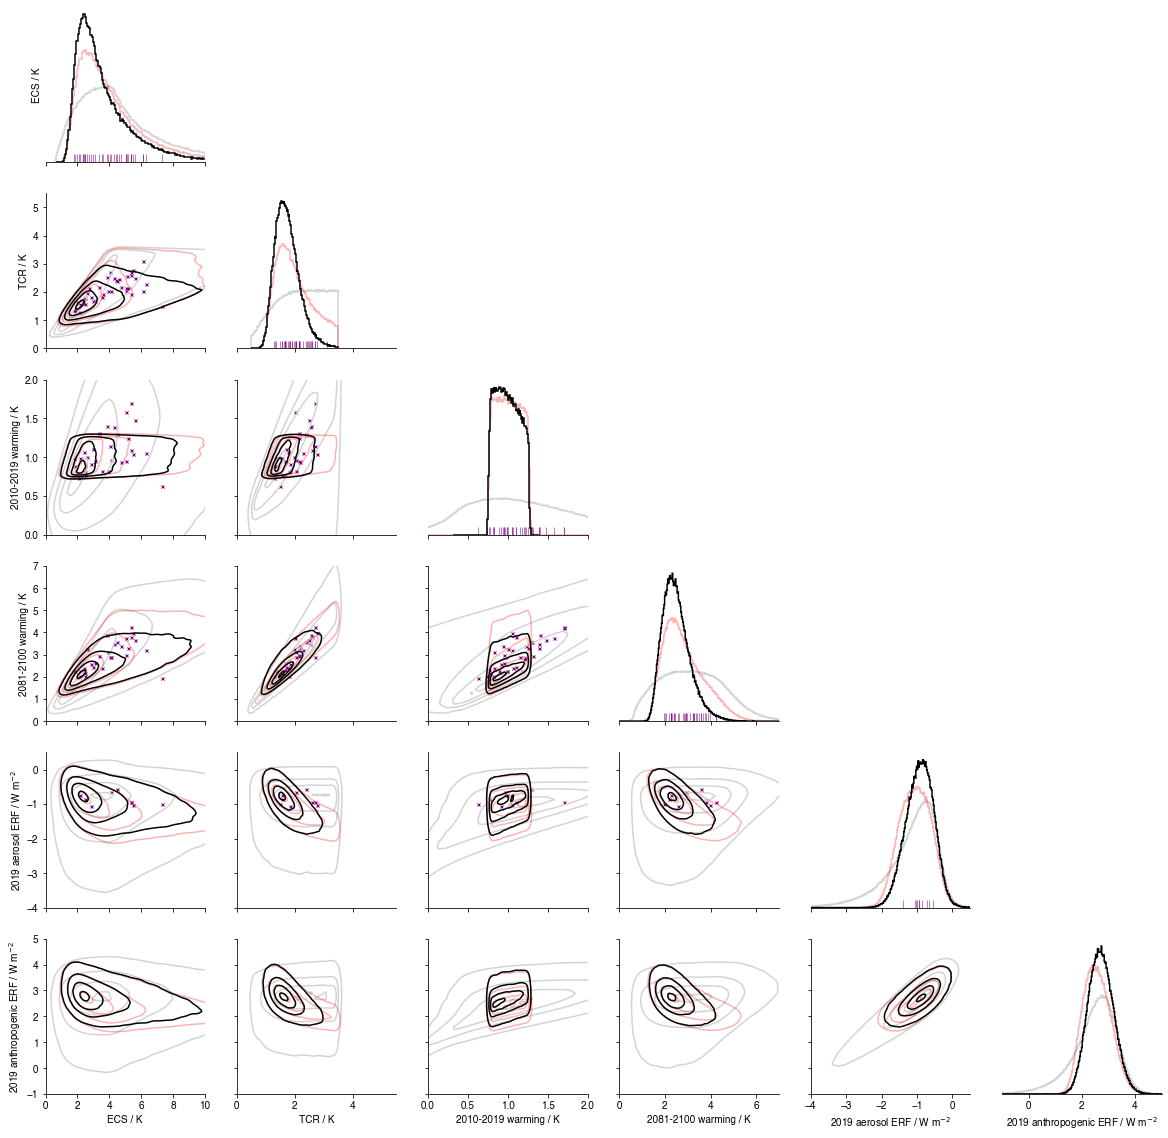

In [12]:
## obtain some cmip6 parameter ranges for tas / ECS / TCR / aer_2019

## get the actual historical / ssp data:
ssp_tas = pd.read_csv('../tools/cmip6_data/ssp_tas.csv',index_col=0)
hist_tas = pd.read_csv('../tools/cmip6_data/hist_tas.csv',index_col=0).iloc[1:]

for i,x in enumerate(['source','member','variable','experiment']):
    ssp_tas.loc[x] = [x.split('_')[i+1] for x in ssp_tas.columns]
for i,x in enumerate(['source','member']):    
    hist_tas.loc[x] = [x.split('_')[i+1] for x in hist_tas.columns]
    

ssp_tas=ssp_tas.T.set_index(['source','member','experiment']).T.drop('variable').apply(pd.to_numeric)
hist_tas=hist_tas.T.set_index(['source','member']).T.apply(pd.to_numeric)
ssp_tas['year']=[int(x) for x in ssp_tas.index]
ssp_tas = ssp_tas.set_index('year')
ssp_tas = ssp_tas.reindex(np.arange(1850,2301))

hist_tas['year']=[int(x) for x in hist_tas.index]
hist_tas = hist_tas.set_index('year')

for modmem in hist_tas.columns:
    if modmem in ssp_tas.columns.droplevel(-1):
        for exp in ssp_tas.loc[1850:2014,modmem].columns:
            ssp_tas.loc[1850:2014,(*modmem,exp)] = hist_tas.loc[1850:2014,modmem]
            
## response params
CMIP6_response_params = pd.read_csv('../Parameter_Sets/CMIP6_stoch_Geoffrey_response.csv',index_col=0)

def BuildMat(params):
#     param_names = ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx','F_2x']
    A = np.array([[-1*params[0],0,0,0],\
                     [1/params[1],-1*(params[4]+params[5])/params[1],params[5]/params[1],0],\
                     [0,params[5]/params[2],-1*(params[5]+params[7]*params[6])/params[2],params[7]*params[6]/params[2]],\
                     [0,0,params[6]/params[3],-1*params[6]/params[3]]])
    k = A.shape[0]
    b = np.array([params[0],0,0,0]).T
    Q = np.zeros((4,4))
    Q[0,0] = params[8]**2
    Q[1,1] = (params[9]/params[1])**2
    A_d = sp.linalg.expm(A)
    b_d = sp.linalg.solve(A, (A_d - np.identity(k)) @ b)
    ## use Van Loan (1978) to compute the matrix exponential
    H = np.zeros((k*2,k*2))
    H[:k,:k] = -A
    H[:k,k:] = Q
    H[k:,k:] = A.T
    G = sp.linalg.expm(H)
    Q_d = G[k:,k:].T @ G[:k,k:]
    C_d = np.array([[0,1,0,0],\
                   [1,-1*params[4],(1-params[7])*params[6],-1*(1-params[7])*params[6]]])
    
    return A,b,Q,A_d,b_d,Q_d,C_d

def convert_geoffrey_to_FaIR(params):
#     ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx','F_4x']

    A,b,Q,A_d,b_d,Q_d,C_d = BuildMat(params)
    eigval,eigvec = np.linalg.eig(A[1:,1:])
    tau = -1/eigval
    q = tau * ( eigvec[0,:] * np.linalg.inv(eigvec)[:,0] ) / params[1]
    
    order = np.argsort(tau)
    
    return pd.DataFrame([tau[order],q[order]],index=['d','q'],columns=[1,2,3])

CMIP6_response_params.loc['ECS'] = np.nan
CMIP6_response_params.loc['TCR'] = np.nan
for model in CMIP6_response_params.columns:
    fair_params = pd.concat([convert_geoffrey_to_FaIR(CMIP6_response_params.loc[:'F_4x',model].values)],axis=1,keys=[model])
    CMIP6_response_params.loc[['ECS','TCR'],model] = q_to_tcr_ecs(fair_params,F_2x = CMIP6_response_params.loc['F_2x',model]).iloc[:,0]
CMIP6_response_params.loc['RWF'] = CMIP6_response_params.loc['TCR'] / CMIP6_response_params.loc['ECS']


# ERFari/aci: APRP data very noisy so we use the emissions based fits:
ERFari_params = pd.read_csv('../Parameter_Sets/CMIP6_ERFari.csv',index_col=0)
ERFaci_params = pd.read_csv('../Parameter_Sets/CMIP6_ERFaci.csv',index_col=0)

ssp_emms = RCMIP_to_GIR_input_emms('ssp245').interpolate().reindex(np.arange(1750,2101))
ssp_emms -= ssp_emms.loc[1750] # emissions relative to 1750 values

CMIP6_aer_forc_2019 = pd.DataFrame(index=ERFari_params.index,columns=['aci','ari','aer'])

for model in CMIP6_aer_forc_2019.index:
    CMIP6_aer_forc_2019.loc[model,'ari'] = ssp_emms.loc[2019,'so2']*ERFari_params.loc[model,'so2'] + ssp_emms.loc[2019,'bc']*ERFari_params.loc[model,'bc'] + ssp_emms.loc[2019,'oc']*ERFari_params.loc[model,'oc']
    CMIP6_aer_forc_2019.loc[model,'aci'] = ERFaci_params.loc[model,'beta'] * np.log(1+ssp_emms.loc[2019,'so2']/ERFaci_params.loc[model,'s']) + ERFaci_params.loc[model,'alpha']*(ssp_emms.loc[2019,'bc']+ssp_emms.loc[2019,'oc'])
    CMIP6_aer_forc_2019.loc[model,'aer'] = CMIP6_aer_forc_2019.loc[model,'aci'] + CMIP6_aer_forc_2019.loc[model,'ari']
    
baseline = [1861,1880]

plot_cmip6_tas2100 = ssp_tas.loc[:].xs('ssp245',axis=1,level=-1).drop(('KACE-1-0-G','r3i1p1f1'),axis=1).groupby(level=0,axis=1).mean()
plot_cmip6_tas2100 = plot_cmip6_tas2100 - plot_cmip6_tas2100.loc[baseline[0]:baseline[1]].mean()

def custom_kde(x,y):
    
    ## first remove the FAR outliers (5-sigma) from x and y in turn
    
    x_rank = np.argsort(x)
    x = x[x_rank]
    y = y[x_rank]
    num_outlier_high = -1*(x>(x.mean()+5.2*x.std())).sum()
    num_outlier_low = (x<(x.mean()-5.2*x.std())).sum()
    if not num_outlier_high:
        num_outlier_high = None
    if not num_outlier_low:
        num_outlier_low = None
    x = x[num_outlier_low:num_outlier_high]
    y = y[num_outlier_low:num_outlier_high]


    y_rank = np.argsort(y)
    x = x[y_rank]
    y = y[y_rank]
    num_outlier_high = -1*(y>(y.mean()+5.2*y.std())).sum()
    num_outlier_low = (y<(y.mean()-5.2*y.std())).sum()
    if not num_outlier_high:
        num_outlier_high = None
    if not num_outlier_low:
        num_outlier_low = None
    x = x[num_outlier_low:num_outlier_high]
    y = y[num_outlier_low:num_outlier_high]
    
    gridsize=100
    k = sp.stats.kde.gaussian_kde([x,y])
    xi,yi = np.mgrid[x.min()-0.5:x.max()+0.5:gridsize*1j,y.min()-0.5:y.max()+0.5:gridsize*1j]
    zi = k(np.vstack([xi.flatten(),yi.flatten()])).reshape(xi.shape)
    dens_vals = np.linspace(0,zi.max(),gridsize)
    zi_int = ((zi>=dens_vals[:,None,None])*zi).sum(axis=(1,2))/zi.sum()
    zi_int_to_dens = sp.interpolate.interp1d(zi_int,dens_vals)
    dens_contours = zi_int_to_dens([0.95,0.67,0.33,0.05])
    
    return xi,yi,zi,dens_contours

## create a correlation matrix plot:

cor_vars = ['ECS','TCR','T_10s','T_EoC','aer_2019','anthro_2019']

map_cor_vars = dict(zip(cor_vars,['ECS / K','TCR / K','2010-2019 warming / K','2081-2100 warming / K','2019 aerosol ERF / W m$^{-2}$','2019 anthropogenic ERF / W m$^{-2}$']))

fig,ax = plt.subplots(len(cor_vars),len(cor_vars),figsize=(20,20))

[ax[i,j].set_visible(False) for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if j>i]

## plot the distributions:

for i in np.arange(len(cor_vars)):
    ax[i,i].hist(ALTERNATIVE.loc[cor_vars[i]].values.flatten(),histtype='step',color='lightgrey',density=True,lw=1.5)
    ax[i,i].hist(ALTERNATIVE.loc[cor_vars[i],ALTERNATIVE.loc['constrain_level'].astype(bool)].values.flatten(),histtype='step',color='red',density=True,lw=1.5,alpha=0.3)
    ax[i,i].hist(ALTERNATIVE.loc[cor_vars[i],ALTERNATIVE.loc['constrain_multi'].astype(bool)].values.flatten(),histtype='step',color='k',density=True,lw=1.5)
    
    
## do some kde plots
import multiprocessing
def kde_wrapper(i,j,constrain):
    if constrain:
        result = custom_kde(ALTERNATIVE.loc[cor_vars[j],ALTERNATIVE.loc[constrain].astype(bool)].values.flatten(),ALTERNATIVE.loc[cor_vars[i],ALTERNATIVE.loc[constrain].astype(bool)].values.flatten())
    else:
        result = custom_kde(ALTERNATIVE.loc[cor_vars[j]].values.flatten(),ALTERNATIVE.loc[cor_vars[i]].values.flatten())
        
    return result
        
# derive the kdes:
        
P1=multiprocessing.Pool(processes=4)
plot_indices = [[i,j,False] for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if j<i]
kde_ALT = P1.starmap(kde_wrapper,plot_indices)
plot_indices = [[i,j,'constrain_level'] for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if j<i]
kde_ALT_level = P1.starmap(kde_wrapper,plot_indices)
plot_indices = [[i,j,'constrain_multi'] for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if j<i]
kde_ALT_constrain = P1.starmap(kde_wrapper,plot_indices)
P1.close()

# plot the kdes:
[ax[x[0],x[1]].contour(kde_ALT[i][0],kde_ALT[i][1],kde_ALT[i][2],kde_ALT[i][3],colors='lightgrey') for i,x in enumerate(plot_indices)]
[ax[x[0],x[1]].contour(kde_ALT_level[i][0],kde_ALT_level[i][1],kde_ALT_level[i][2],kde_ALT_level[i][3],colors='red',alpha=0.3) for i,x in enumerate(plot_indices)]
[ax[x[0],x[1]].contour(kde_ALT_constrain[i][0],kde_ALT_constrain[i][1],kde_ALT_constrain[i][2],kde_ALT_constrain[i][3],colors='k') for i,x in enumerate(plot_indices)]

# plot CMIP6 samples:
cmip6_samples = [CMIP6_response_params.loc['ECS'],CMIP6_response_params.loc['TCR'],plot_cmip6_tas2100.loc[2010:2019].mean(),plot_cmip6_tas2100.loc[2081:2100].mean(),CMIP6_aer_forc_2019.aer]
for i in np.arange(5):
    for j in np.arange(5):
        if j<i:
            intersection = list(set(cmip6_samples[i].index).intersection(set(cmip6_samples[j].index)))
            ax[i,j].plot(cmip6_samples[j].loc[intersection],cmip6_samples[i].loc[intersection],'x',color='purple',ms=3,zorder=0)

axes_lims = [[0,10],[0,5.5],[0,2],[0,7],[-4,0.5],[-1,5]]

[sn.rugplot(cmip6_samples[i],ax=ax[i,i],color='purple',lw=0.5) for i in np.arange(5)]

[ax[i,j].set_xlim(axes_lims[j]) for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars))]
[ax[i,j].set_ylim(axes_lims[i]) for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if j<i]
[ax[i,j].set_ylabel(map_cor_vars[cor_vars[i]]) for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if j==0]
[ax[i,j].set_xlabel(map_cor_vars[cor_vars[j]]) for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if i==5]

## diagonal axes
[ax[i,i].spines[pos].set_visible(False) for i in np.arange(len(cor_vars)) for pos in ['top','right','left']]
[ax[i,i].tick_params(left=False,labelleft=False) for i in np.arange(len(cor_vars))]

[ax[i,j].spines[pos].set_visible(False) for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) for pos in ['top','right']]
[ax[i,j].tick_params(labelleft=False) for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if j!=0]
[ax[i,j].tick_params(labelbottom=False) for i in np.arange(len(cor_vars)) for j in np.arange(len(cor_vars)) if i!=5]
print()

In [13]:
[fig.savefig('/home/leachl/Documents/Simple_models/FaIR_v2-0_paper/Plots/NROY_corr_1e6mem_alt_prior.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf','svg']]

[None, None, None]

#### A quick figure displaying the climate sensitivity results in the context of other studies

In [40]:
## get CMIP6 climate sensitivities

response_df = pd.read_csv('../Parameter_Sets/CMIP6_stoch_Geoffrey_response.csv',index_col=0)

def BuildMat(params):
#     param_names = ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx','F_2x']
    A = np.array([[-1*params[0],0,0,0],\
                     [1/params[1],-1*(params[4]+params[5])/params[1],params[5]/params[1],0],\
                     [0,params[5]/params[2],-1*(params[5]+params[7]*params[6])/params[2],params[7]*params[6]/params[2]],\
                     [0,0,params[6]/params[3],-1*params[6]/params[3]]])
    k = A.shape[0]
    b = np.array([params[0],0,0,0]).T
    Q = np.zeros((4,4))
    Q[0,0] = params[8]**2
    Q[1,1] = (params[9]/params[1])**2
    A_d = sp.linalg.expm(A)
    b_d = sp.linalg.solve(A, (A_d - np.identity(k)) @ b)
    ## use Van Loan (1978) to compute the matrix exponential
    H = np.zeros((k*2,k*2))
    H[:k,:k] = -A
    H[:k,k:] = Q
    H[k:,k:] = A.T
    G = sp.linalg.expm(H)
    Q_d = G[k:,k:].T @ G[:k,k:]
    C_d = np.array([[0,1,0,0],\
                   [1,-1*params[4],(1-params[7])*params[6],-1*(1-params[7])*params[6]]])
    
    return A,b,Q,A_d,b_d,Q_d,C_d

def convert_geoffrey_to_FaIR(params):
#     ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx','F_4x']

    A,b,Q,A_d,b_d,Q_d,C_d = BuildMat(params)
    eigval,eigvec = np.linalg.eig(A[1:,1:])
    tau = -1/eigval
    q = tau * ( eigvec[0,:] * np.linalg.inv(eigvec)[:,0] ) / params[1]
    
    order = np.argsort(tau)
    
    return pd.DataFrame([tau[order],q[order]],index=['d','q'],columns=[1,2,3])

response_df.loc['ECS'] = np.nan
response_df.loc['TCR'] = np.nan
for model in response_df.columns:
    fair_params = pd.concat([convert_geoffrey_to_FaIR(response_df.loc[:'F_4x',model].values)],axis=1,keys=[model])
    response_df.loc[['ECS','TCR'],model] = q_to_tcr_ecs(fair_params,F_2x = response_df.loc['F_2x',model]).iloc[:,0]
response_df.loc['RWF'] = response_df.loc['TCR'] / response_df.loc['ECS']

In [48]:
# response_df
# now calculate the Gregory effECS:

abrupt4xdata = pd.read_csv('../tools/cmip6_data/abrupt4x_tas_N_bias_corr.csv',header=[0,1],index_col=0)
for model in abrupt4xdata.columns.levels[0]:
    response_df.loc['effECS',model] = sp.stats.linregress(abrupt4xdata[model].loc[:149,'N'].dropna(),abrupt4xdata[model].loc[:149,'tas'].dropna()).intercept/2

In [130]:
clim_sens_comp = pd.DataFrame(columns=pd.MultiIndex.from_product([['ECS','TCR'],[5,17,50,83,95]]))
clim_sens_comp.loc['FULL','ECS'] = [1.91,2.55,3.73,5.43,7.26]
clim_sens_comp.loc['FULL','TCR'] = [1.18,1.53,2.06,2.62,3.02]

clim_sens_comp.loc['CONSTRAINED','ECS'] = [1.94,2.36,3.17,4.45,5.84]
clim_sens_comp.loc['CONSTRAINED','TCR'] = [1.25,1.45,1.77,2.13,2.41]

clim_sens_comp.loc['ALTERNATIVE','ECS'] = [1.74,2.14,3.14,5.20,7.42]
clim_sens_comp.loc['ALTERNATIVE','TCR'] = [1.15,1.34,1.69,2.14,2.54]

clim_sens_comp.loc['Njisse','ECS'] = [1.52,1.9,2.6,3.4,4.03]
clim_sens_comp.loc['Njisse','TCR'] = [1.0,1.29,1.68,2.05,2.3]

clim_sens_comp.loc['Tokarska','ECS'] = [np.nan]*5
clim_sens_comp.loc['Tokarska','TCR'] = [np.nan,1.2,1.6,1.99,np.nan]

clim_sens_comp.loc['JCM','ECS'] = [1.72,np.nan,2.83,np.nan,4.12]
clim_sens_comp.loc['JCM','TCR'] = [1.16,np.nan,1.67,np.nan,2.16]

clim_sens_comp.loc['Sherwood','ECS'] = [2.3,2.6,3.1,3.9,4.7]
clim_sens_comp.loc['Sherwood','TCR'] = [np.nan,1.5,1.8,2.2,np.nan]

clim_sens_comp.loc['Sherwood-robust','ECS'] = [2.0,2.3,np.nan,4.1,5.7]
clim_sens_comp.loc['Sherwood-robust','TCR'] = [np.nan]*5

## response_df

clim_sens_comp.loc['CMIP6','ECS'] = response_df.loc['ECS'].quantile([0.05,0.166,0.5,0.833,0.95]).values
clim_sens_comp.loc['CMIP6*','ECS'] = response_df.loc['effECS'].quantile([0.05,0.166,0.5,0.833,0.95]).values
clim_sens_comp.loc['CMIP6','TCR'] = response_df.loc['TCR'].quantile([0.05,0.166,0.5,0.833,0.95]).values

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  import sys
/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  # Remove the CWD from sys.path while we load stuff.


[None, None, None]

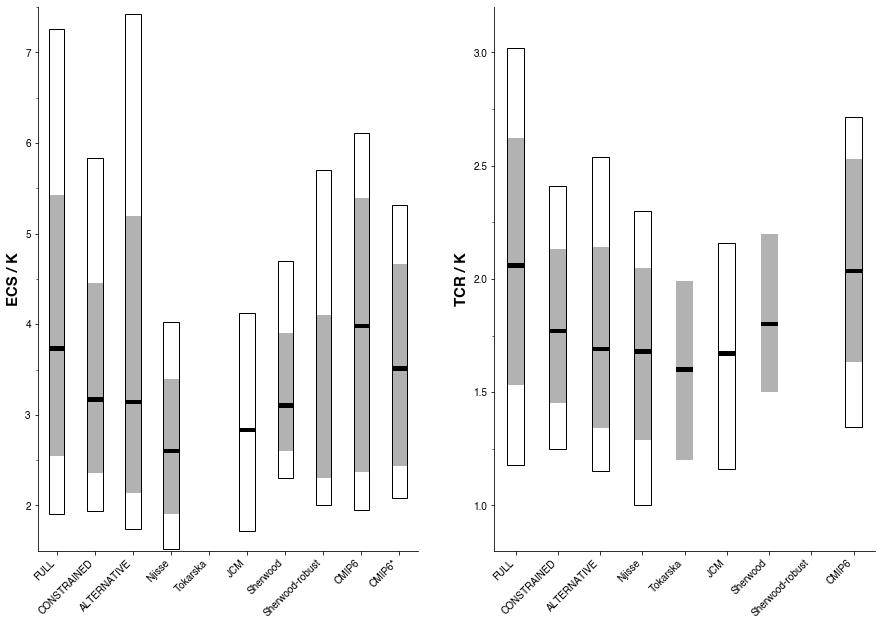

In [133]:
clim_sens_comp['ECS']

fig,ax = plt.subplots(1,2,figsize=(15,10))

for i,source in enumerate(clim_sens_comp.index):
    
    ax[0].bar(i,clim_sens_comp.loc[source,'ECS'][95]-clim_sens_comp.loc[source,'ECS'][5],0.4,clim_sens_comp.loc[source,'ECS'][5],color='',ec='k')
    ax[0].bar(i,clim_sens_comp.loc[source,'ECS'][83]-clim_sens_comp.loc[source,'ECS'][17],0.4,clim_sens_comp.loc[source,'ECS'][17],color='k',alpha=0.3)
    
    ax[1].bar(i,clim_sens_comp.loc[source,'TCR'][95]-clim_sens_comp.loc[source,'TCR'][5],0.4,clim_sens_comp.loc[source,'TCR'][5],color='',ec='k')
    ax[1].bar(i,clim_sens_comp.loc[source,'TCR'][83]-clim_sens_comp.loc[source,'TCR'][17],0.4,clim_sens_comp.loc[source,'TCR'][17],color='k',alpha=0.3)
    
    ax[0].bar(i,0.05,0.4,clim_sens_comp.loc[source,'ECS'][50]-0.025,color='k',)
    ax[1].bar(i,0.05*0.4,0.4,clim_sens_comp.loc[source,'TCR'][50]-0.025*0.4,color='k',)
    

[a.set_xticks(np.arange(clim_sens_comp.index.size)) for a in ax]
[a.set_xticklabels(clim_sens_comp.index,ha='right') for a in ax]
[a.tick_params(axis='x',rotation=45) for a in ax]

[a.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2)) for a in ax]

[a.spines[pos].set_visible(False) for a in ax for pos in ['right','top']]

ax[0].set_xlim(-0.5,clim_sens_comp.index.size-0.5)
ax[1].set_xlim(-0.5,clim_sens_comp.index.size-1.5)

ax[0].set_ylim(1.5,7.5)
ax[1].set_ylim(0.8,3.2)

ax[0].set_ylabel('ECS / K',fontweight='bold',fontsize=15)
ax[1].set_ylabel('TCR / K',fontweight='bold',fontsize=15)

[fig.savefig('/home/leachl/Documents/Simple_models/FaIR_v2-0_paper/Plots/Clim_sens_comparison.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf','svg']]

## Re-running the ensembles
Start here to the constrained ensemble over a range of scenarios (largely for the 2100 temperature).

In [2]:
## get constrained parameter ensembles:

default_params = pd.read_csv('../Parameter_Sets/Complete_gas_cycle_params.csv',skiprows=1,index_col=0)
forcing_namelist = list(default_params.columns)

param_categories = {}
param_categories['other_wmghgs'] = ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8','carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methyl_bromide', 'methyl_chloride', 'nf3', 'sf6', 'so2f2', 'halon1202']
param_categories['carbon_dioxide'] = ['carbon_dioxide']
param_categories['methane'] = ['methane']
param_categories['nitrous_oxide'] = ['nitrous_oxide']
param_categories['trop_o3'] = [x for x in forcing_namelist if '|trop_o3' in x]
param_categories['strat_o3'] = [x for x in forcing_namelist if '|strat_o3' in x]
param_categories['strat_h2o'] = [x for x in forcing_namelist if '|strat_h2o' in x]
param_categories['ari'] = ['so2', 'nox', 'co', 'nmvoc', 'bc', 'nh3','oc','nox_avi']
param_categories['aci'] = ['so2|aci','oc|aci','bc|aci']
param_categories['bc_on_snow'] = ['bc|bc_on_snow']
param_categories['contrails'] = ['nox_avi|contrails']

In [ ]:
basedir = '../Parameter_Sets/NROY/'

for ssp in [x for x in RCMIP_emms.index.levels[1].unique() if 'ssp' in x]:
    
    ssp_emms = RCMIP_to_GIR_input_emms(ssp).interpolate().reindex(np.arange(1750,2101))
    ssp_emms -= ssp_emms.loc[1750] # emissions relative to 1750 values
    sf = GCP_historical_emissions.sum(axis=1).loc[2015] / ssp_emms.loc[2015,'carbon_dioxide']
    ssp_emms.loc[:2014,'carbon_dioxide'] = GCP_historical_emissions.sum(axis=1).loc[1750:2014]
    ssp_emms.loc[2015:2025,'carbon_dioxide'] *= np.linspace(sf,1,11)
    
    ALL_output = []

    for param_set_start in np.arange(0,1000000,10000):

        gas_param_file,response_param_file,level_constraint_file,rate_constrain_file,ext_forc_file = [basedir+x+'_mem'+str(param_set_start)+'-mem'+str(param_set_start+9999)+'_v1.pkl' for x in ['gas_params','response_params','temp_constraint','rate_constraint','EXT_forc']]
        level_constraint = pd.read_pickle(level_constraint_file)
        rate_constraint = pd.read_pickle(rate_constrain_file)
        full_constraint = level_constraint & rate_constraint
        NROY_mems = full_constraint.index.levels[0][full_constraint]
        gas_params = pd.read_pickle(gas_param_file)
        response_params = pd.read_pickle(response_param_file)
        EXT_forc_sfs = pd.read_pickle(ext_forc_file)
        
        N = full_constraint.index.size
        
        erf_ar6 = pd.read_csv('https://raw.githubusercontent.com/Priestley-Centre/ssp_erf/master/SSPs/ERF_'+ssp+'_1750-2500.csv',index_col=0,dtype=float)
        ## LUC
        LUC_forc = erf_ar6[['land_use']].reindex(np.arange(1750,2101)).values
        LUC_forc_sfs = EXT_forc_sfs.loc['LUC'].values
        LUC_forc_ensemble = LUC_forc_sfs[None] * LUC_forc

        ## Natural
        volc_forc = erf_ar6[['volcanic']].reindex(np.arange(1750,2101)).values
        volc_forc_sfs = EXT_forc_sfs.loc['volc'].values
        volc_forc_ensemble = volc_forc_sfs[None] * volc_forc
        sol_forc = erf_ar6[['solar']].reindex(np.arange(1750,2101)).values
        sol_forc_sfs = EXT_forc_sfs.loc['sol'].values
        sol_forc_ensemble = sol_forc_sfs[None] * sol_forc

        ssp_forc = pd.DataFrame(LUC_forc_ensemble+sol_forc_ensemble+volc_forc_ensemble,index=np.arange(1750,2101),columns=pd.MultiIndex.from_product([EXT_forc_sfs.columns,['forcing']]) )
    
        ssp_emms_run = pd.concat([ssp_emms]*N,axis=1,keys=[x[0] for x in full_constraint.index])

        results = run_GIR(emissions_in=ssp_emms_run,forcing_in=ssp_forc,gas_parameters=gas_params,thermal_parameters=response_params,show_run_info=False)

        _output = pd.DataFrame(columns = [x[0] for x in full_constraint.index])

        _output.loc['T_2100',:] = (results['T'].loc[2100]-results['T'].loc[1861:1880].mean()).reset_index(level=0).set_index('Scenario').iloc[:,0]
        _output.loc['T_2014',:] = (results['T'].loc[2014]-results['T'].loc[1861:1880].mean()).reset_index(level=0).set_index('Scenario').iloc[:,0]

        for forc_cat in param_categories.keys():

            _output.loc[forc_cat+'_2019',:] = results['RF'].loc[2019,(slice(None),param_categories[forc_cat])].groupby(level=0).sum()
            _output.loc[forc_cat+'_2100',:] = results['RF'].loc[2100,(slice(None),param_categories[forc_cat])].groupby(level=0).sum()
            
        _output.loc['LUC_2019',:] = EXT_forc_sfs.loc['LUC'] * erf_ar6.loc[2019,'land_use']
        _output.loc['LUC_2100',:] = EXT_forc_sfs.loc['LUC'] * erf_ar6.loc[2100,'land_use']

        _output.loc['GHG_2019',:] = _output.loc[[x+'_2019' for x in ['other_wmghgs', 'carbon_dioxide', 'methane', 'nitrous_oxide', 'trop_o3', 'strat_o3', 'strat_h2o']]].sum()
        _output.loc['GHG_2100',:] = _output.loc[[x+'_2100' for x in ['other_wmghgs', 'carbon_dioxide', 'methane', 'nitrous_oxide', 'trop_o3', 'strat_o3', 'strat_h2o']]].sum()
        _output.loc['aer_2019',:] = _output.loc[[x+'_2019' for x in ['aci','ari']]].sum()
        _output.loc['aer_2100',:] = _output.loc[[x+'_2100' for x in ['aci','ari']]].sum()
        _output.loc['anthro_2019',:] = _output.loc[[x+'_2019' for x in param_categories.keys()]+['LUC_2019']].sum()
        _output.loc['anthro_2100',:] = _output.loc[[x+'_2100' for x in param_categories.keys()]+['LUC_2100']].sum()

        _output.loc['constrain_level',:] = level_constraint.reset_index(level=0).set_index('Scenario').iloc[:,0]
        _output.loc['constrain_rate',:] = level_constraint.reset_index(level=0).set_index('Scenario').iloc[:,0]
        _output.loc['constrain_multi',:] = full_constraint.reset_index(level=0).set_index('Scenario').iloc[:,0]
        
        ALL_output += [_output]
        
    pd.concat(ALL_output,axis=1).to_csv('/home/leachl/Documents/Simple_models/FaIR_v2-0_paper/NROY_results/'+ssp+'.csv')

 30%|██▉       | 104/350 [00:07<00:16, 14.76 timestep/s]